<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Lists" data-toc-modified-id="Lists-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lists</a></span></li><li><span><a href="#Formatting-functions" data-toc-modified-id="Formatting-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Formatting functions</a></span></li><li><span><a href="#API-call-functions" data-toc-modified-id="API-call-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>API call functions</a></span></li></ul></li><li><span><a href="#Data-aquisition" data-toc-modified-id="Data-aquisition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data aquisition</a></span><ul class="toc-item"><li><span><a href="#Fetch-online-data" data-toc-modified-id="Fetch-online-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fetch online data</a></span></li><li><span><a href="#Format-data" data-toc-modified-id="Format-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Format data</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Check-changes" data-toc-modified-id="Check-changes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check changes</a></span><ul class="toc-item"><li><span><a href="#Load-latest-file" data-toc-modified-id="Load-latest-file-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load latest file</a></span></li><li><span><a href="#Generate-changelog" data-toc-modified-id="Generate-changelog-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate changelog</a></span></li></ul></li><li><span><a href="#Data-visualisation" data-toc-modified-id="Data-visualisation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data visualisation</a></span><ul class="toc-item"><li><span><a href="#Full-data" data-toc-modified-id="Full-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Full data</a></span></li><li><span><a href="#Card-types" data-toc-modified-id="Card-types-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Card types</a></span></li><li><span><a href="#Monsters" data-toc-modified-id="Monsters-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Monsters</a></span><ul class="toc-item"><li><span><a href="#Attributes" data-toc-modified-id="Attributes-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Attributes</a></span></li><li><span><a href="#Primary-types" data-toc-modified-id="Primary-types-4.3.2"><span class="toc-item-num">4.3.2&nbsp;&nbsp;</span>Primary types</a></span><ul class="toc-item"><li><span><a href="#Has-effect-discrimination" data-toc-modified-id="Has-effect-discrimination-4.3.2.1"><span class="toc-item-num">4.3.2.1&nbsp;&nbsp;</span>Has effect discrimination</a></span></li><li><span><a href="#Is-pendulum-discrimination" data-toc-modified-id="Is-pendulum-discrimination-4.3.2.2"><span class="toc-item-num">4.3.2.2&nbsp;&nbsp;</span>Is pendulum discrimination</a></span></li><li><span><a href="#By-attribute" data-toc-modified-id="By-attribute-4.3.2.3"><span class="toc-item-num">4.3.2.3&nbsp;&nbsp;</span>By attribute</a></span></li></ul></li><li><span><a href="#Secondary-types" data-toc-modified-id="Secondary-types-4.3.3"><span class="toc-item-num">4.3.3&nbsp;&nbsp;</span>Secondary types</a></span><ul class="toc-item"><li><span><a href="#By-attribute" data-toc-modified-id="By-attribute-4.3.3.1"><span class="toc-item-num">4.3.3.1&nbsp;&nbsp;</span>By attribute</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.3.3.2"><span class="toc-item-num">4.3.3.2&nbsp;&nbsp;</span>By secondary type</a></span></li></ul></li><li><span><a href="#Monster-types" data-toc-modified-id="Monster-types-4.3.4"><span class="toc-item-num">4.3.4&nbsp;&nbsp;</span>Monster types</a></span><ul class="toc-item"><li><span><a href="#By-Attribute" data-toc-modified-id="By-Attribute-4.3.4.1"><span class="toc-item-num">4.3.4.1&nbsp;&nbsp;</span>By Attribute</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.3.4.2"><span class="toc-item-num">4.3.4.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.3.4.3"><span class="toc-item-num">4.3.4.3&nbsp;&nbsp;</span>By secondary type</a></span></li></ul></li><li><span><a href="#Effect-type" data-toc-modified-id="Effect-type-4.3.5"><span class="toc-item-num">4.3.5&nbsp;&nbsp;</span>Effect type</a></span></li><li><span><a href="#ATK" data-toc-modified-id="ATK-4.3.6"><span class="toc-item-num">4.3.6&nbsp;&nbsp;</span>ATK</a></span></li><li><span><a href="#DEF" data-toc-modified-id="DEF-4.3.7"><span class="toc-item-num">4.3.7&nbsp;&nbsp;</span>DEF</a></span></li><li><span><a href="#Level/Rank" data-toc-modified-id="Level/Rank-4.3.8"><span class="toc-item-num">4.3.8&nbsp;&nbsp;</span>Level/Rank</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.8.1"><span class="toc-item-num">4.3.8.1&nbsp;&nbsp;</span>ATK statistics</a></span></li><li><span><a href="#DEF-statistics" data-toc-modified-id="DEF-statistics-4.3.8.2"><span class="toc-item-num">4.3.8.2&nbsp;&nbsp;</span>DEF statistics</a></span></li></ul></li><li><span><a href="#Pendulum-scale" data-toc-modified-id="Pendulum-scale-4.3.9"><span class="toc-item-num">4.3.9&nbsp;&nbsp;</span>Pendulum scale</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.9.1"><span class="toc-item-num">4.3.9.1&nbsp;&nbsp;</span>ATK statistics</a></span></li><li><span><a href="#DEF-statistics" data-toc-modified-id="DEF-statistics-4.3.9.2"><span class="toc-item-num">4.3.9.2&nbsp;&nbsp;</span>DEF statistics</a></span></li><li><span><a href="#Level/Rank-statistics" data-toc-modified-id="Level/Rank-statistics-4.3.9.3"><span class="toc-item-num">4.3.9.3&nbsp;&nbsp;</span>Level/Rank statistics</a></span></li></ul></li><li><span><a href="#Link" data-toc-modified-id="Link-4.3.10"><span class="toc-item-num">4.3.10&nbsp;&nbsp;</span>Link</a></span><ul class="toc-item"><li><span><a href="#ATK-statistics" data-toc-modified-id="ATK-statistics-4.3.10.1"><span class="toc-item-num">4.3.10.1&nbsp;&nbsp;</span>ATK statistics</a></span></li></ul></li><li><span><a href="#Link-Arrows" data-toc-modified-id="Link-Arrows-4.3.11"><span class="toc-item-num">4.3.11&nbsp;&nbsp;</span>Link Arrows</a></span><ul class="toc-item"><li><span><a href="#By-combination" data-toc-modified-id="By-combination-4.3.11.1"><span class="toc-item-num">4.3.11.1&nbsp;&nbsp;</span>By combination</a></span></li><li><span><a href="#By-unique" data-toc-modified-id="By-unique-4.3.11.2"><span class="toc-item-num">4.3.11.2&nbsp;&nbsp;</span>By unique</a></span></li><li><span><a href="#By-link" data-toc-modified-id="By-link-4.3.11.3"><span class="toc-item-num">4.3.11.3&nbsp;&nbsp;</span>By link</a></span></li></ul></li></ul></li><li><span><a href="#Spell-&amp;-Trap" data-toc-modified-id="Spell-&amp;-Trap-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Spell &amp; Trap</a></span><ul class="toc-item"><li><span><a href="#Properties" data-toc-modified-id="Properties-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Properties</a></span></li><li><span><a href="#Effect-type" data-toc-modified-id="Effect-type-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Effect type</a></span><ul class="toc-item"><li><span><a href="#Spell-&amp;-Trap-discrimination" data-toc-modified-id="Spell-&amp;-Trap-discrimination-4.4.2.1"><span class="toc-item-num">4.4.2.1&nbsp;&nbsp;</span>Spell &amp; Trap discrimination</a></span></li></ul></li></ul></li><li><span><a href="#Archseries" data-toc-modified-id="Archseries-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Archseries</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-secondary-type" data-toc-modified-id="By-secondary-type-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>By secondary type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.5.4"><span class="toc-item-num">4.5.4&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-property" data-toc-modified-id="By-property-4.5.5"><span class="toc-item-num">4.5.5&nbsp;&nbsp;</span>By property</a></span></li></ul></li><li><span><a href="#Artworks" data-toc-modified-id="Artworks-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Artworks</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.6.2"><span class="toc-item-num">4.6.2&nbsp;&nbsp;</span>By primary type</a></span></li></ul></li><li><span><a href="#Errata" data-toc-modified-id="Errata-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Errata</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.7.1"><span class="toc-item-num">4.7.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-primary-type" data-toc-modified-id="By-primary-type-4.7.2"><span class="toc-item-num">4.7.2&nbsp;&nbsp;</span>By primary type</a></span></li><li><span><a href="#By-artwork" data-toc-modified-id="By-artwork-4.7.3"><span class="toc-item-num">4.7.3&nbsp;&nbsp;</span>By artwork</a></span></li></ul></li><li><span><a href="#TCG-&amp;-OCG-status" data-toc-modified-id="TCG-&amp;-OCG-status-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>TCG &amp; OCG status</a></span><ul class="toc-item"><li><span><a href="#TGC-status" data-toc-modified-id="TGC-status-4.8.1"><span class="toc-item-num">4.8.1&nbsp;&nbsp;</span>TGC status</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.8.1.1"><span class="toc-item-num">4.8.1.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.8.1.2"><span class="toc-item-num">4.8.1.2&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-archseries" data-toc-modified-id="By-archseries-4.8.1.3"><span class="toc-item-num">4.8.1.3&nbsp;&nbsp;</span>By archseries</a></span></li></ul></li><li><span><a href="#OCG-status" data-toc-modified-id="OCG-status-4.8.2"><span class="toc-item-num">4.8.2&nbsp;&nbsp;</span>OCG status</a></span><ul class="toc-item"><li><span><a href="#By-card-type" data-toc-modified-id="By-card-type-4.8.2.1"><span class="toc-item-num">4.8.2.1&nbsp;&nbsp;</span>By card type</a></span></li><li><span><a href="#By-monster-type" data-toc-modified-id="By-monster-type-4.8.2.2"><span class="toc-item-num">4.8.2.2&nbsp;&nbsp;</span>By monster type</a></span></li><li><span><a href="#By-archseries" data-toc-modified-id="By-archseries-4.8.2.3"><span class="toc-item-num">4.8.2.3&nbsp;&nbsp;</span>By archseries</a></span></li></ul></li><li><span><a href="#TCG-vs.-OCG-status" data-toc-modified-id="TCG-vs.-OCG-status-4.8.3"><span class="toc-item-num">4.8.3&nbsp;&nbsp;</span>TCG vs. OCG status</a></span></li></ul></li></ul></li><li><span><a href="#HTML-export" data-toc-modified-id="HTML-export-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>HTML export</a></span></li><li><span><a href="#Searches" data-toc-modified-id="Searches-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Searches</a></span></li></ul></div>

# Preamble

## Imports

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib_venn import venn2
from datetime import datetime
from ast import literal_eval

## Lists

In [6]:
# Attributes to split monsters query
attributes = ['DIVINE', 'LIGHT', 'DARK', 'WATER', 'EARTH', 'FIRE', 'WIND']

# API variables
api_url = 'https://yugipedia.com/api.php'

# Styling dictionaries
arrows_dict = {'Middle-Left': '\u2190', 'Middle-Right': '\u2192', 'Top-Left': '\u2196', 'Top-Center': '\u2191', 'Top-Right': '\u2197', 'Bottom-Left': '\u2199', 'Bottom-Center': '\u2193', 'Bottom-Right': '\u2198'}
card_colors = {'Effect Monster': '#FF8B53', 'Normal Monster': '#FDE68A', 'Ritual Monster': '#9DB5CC', 'Fusion Monster': '#A086B7', 'Synchro Monster': '#CCCCCC', 'Xyz Monster': '#000000', 'Link Monster': '#00008B', 'Pendulum Monster': 'r', 'Monster Card': '#FF8B53', 'Spell Card': '#1D9E74', 'Trap Card': '#BC5A84', 'Monster Token': '#C0C0C0', 'FIRE': '#fd1b1b', 'WATER': '#03a9e6', 'EARTH': '#060d0a', 'WIND': '#77bb58', 'DARK': '#745ea5', 'LIGHT': '#9d8047', 'DIVINE': '#7e6537', 'Level': '#f1a41f'}

## Formatting functions

In [7]:
def extract_results(df):
    df = pd.DataFrame(df['query']['results']).transpose()
    df = pd.DataFrame(df['printouts'].values.tolist())
    return df

def extract_artwork(row):
    result = tuple()
    if 'Category:OCG/TCG cards with alternate artworks' in row:
        result += ('Alternate',)
    if 'Category:OCG/TCG cards with edited artworks' in row:
        result += ('Edited',)
    if result == tuple():
        return np.nan
    else:
        return result

def concat_errata(row):
    result = tuple()
    if row['Name errata']:
        result += ('Name',)
    if row['Type errata']:
        result += ('Type',)
    if result == tuple():
        return np.nan
    else:
        return result 
    
def format_df(input_df, input_errata_df):
    df = pd.DataFrame()
    if 'Name' in input_df.columns:
        df['Name'] = input_df['Name'].dropna().apply(lambda x: x[0])
    if 'Password' in input_df.columns:
        df['Password'] = input_df['Password'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Card type' in input_df.columns:
        df['Card type'] = input_df['Card type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Property' in input_df.columns:
        df['Property'] = input_df['Property'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Primary type' in input_df.columns:
        df['Primary type'] = input_df['Primary type'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Pendulum Monster', y)) if len(y)>0 else []).apply(lambda y: list(filter(lambda z: z != 'Effect Monster', y))[0] if len(y)>1 else (y[0] if len(y)>0 else np.nan))
    if 'Secondary type' in input_df.columns:
        df['Secondary type'] = input_df['Secondary type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Attribute' in input_df.columns:
        df['Attribute'] = input_df['Attribute'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Monster type' in input_df.columns:
        df['Monster type'] = input_df['Monster type'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Level/Rank' in input_df.columns:
        df['Level/Rank'] = input_df['Level/Rank'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'ATK' in input_df.columns:
        df['ATK'] = input_df['ATK'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'DEF' in input_df.columns:
        df['DEF'] = input_df['DEF'].dropna().apply(lambda x: x[0] if len(x)>0 else np.nan)
    if 'Pendulum Scale' in input_df.columns:
        df['Pendulum Scale'] = input_df['Pendulum Scale'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link' in input_df.columns:
        df['Link'] = input_df['Link'].dropna().apply(lambda x: str(x[0]) if len(x)>0 else np.nan)
    if 'Link Arrows' in input_df.columns:
        df['Link Arrows'] = input_df['Link Arrows'].dropna().apply(lambda x: tuple([arrows_dict[i] for i in sorted(x)]) if len(x)>0 else np.nan)
    if 'Effect type' in input_df.columns:
        df['Effect type'] = input_df['Effect type'].dropna().apply(lambda x: tuple(sorted([i['fulltext'] for i in x])) if len(x)>0 else np.nan)
    if 'Archseries' in input_df.columns:
        df['Archseries'] = input_df['Archseries'].dropna().apply(lambda x: tuple(sorted(x)) if len(x)>0 else np.nan)
    if 'Category' in input_df.columns:
        df['Artwork'] = input_df['Category'].dropna().apply(lambda x: [i['fulltext'] for i in x] if len(x)>0 else np.nan).apply(extract_artwork)
    # Erratas column
    if input_errata_df is not None and 'Page name' in input_df.columns:
        df['Errata'] = errata_df.merge(input_df['Page name'].dropna().apply(lambda x: x[0]).rename('Name'), right_on = 'Name', left_index = True).apply(concat_errata,axis = 1)
    #################
    if 'TCG status' in input_df.columns:
        df['TCG status'] = input_df['TCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'OCG status' in input_df.columns:
        df['OCG status'] = input_df['OCG status'].dropna().apply(lambda x: x[0]['fulltext'] if len(x)>0 else np.nan)
    if 'Modification date' in input_df.columns:
        df['Modification date'] = input_df['Modification date'].dropna().apply(lambda x: pd.Timestamp(int(x[0]['timestamp']), unit='s').ctime() if len(x)>0 else np.nan)
    
    return df


## API call functions

In [8]:
def card_query(_password = True, _card_type = True, _property = True, _primary = True, _secondary = True, _attribute = True, _monster_type = True, _stars = True, _atk = True, _def = True, _scale = True, _link = True, _arrows = True, _effect_type = True, _archseries = True, _category = True, _tcg = True, _ocg = True, _date = True, _page_name = True):
    search_string = f'|?English%20name=Name'
    if _password:
        search_string += '|?Password'
    if _card_type:
        search_string += '|?Card%20type'
    if _property:    
        search_string += '|?Property'
    if _primary:
        search_string += '|?Primary%20type'
    if _secondary:
        search_string += '|?Secondary%20type'
    if _attribute:
        search_string += '|?Attribute'
    if _monster_type:
        search_string += '|?Type=Monster%20type'
    if _stars:
        search_string += '|?Stars%20string=Level%2FRank%20'
    if _atk:
        search_string += '|?ATK%20string=ATK'
    if _def:
        search_string += '|?DEF%20string=DEF'
    if _scale:
        search_string += '|?Pendulum%20Scale'
    if _link:
        search_string += '|?Link%20Rating=Link'
    if _arrows:
        search_string += '|?Link%20Arrows'
    if _effect_type:
        search_string += '|?Effect%20type'
    if _archseries:
        search_string += '|?Archseries'
    if _category:
        search_string += '|?category'
    if _tcg:
        search_string += '|?TCG%20status'
    if _ocg:
        search_string += '|?OCG%20status'
    if _date:
        search_string += '|?Modification%20date'
    if _page_name:
        search_string += '|?Page%20name'
    
    return search_string

def fetch_spell(spell_query, step = 5000, limit = 5000):
    print('Downloading Spells')
    spell_df = pd.DataFrame()
    for i in range(int(limit/step)):
        df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Spell%20Cards]]{spell_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
        df = extract_results(df)
        print(f'Iteration {i+1}: {len(df.index)} results')
        spell_df = pd.concat([spell_df, df], ignore_index=True, axis=0)
        if len(df.index)<step:
            break
                
    print(f'- Total\n{len(spell_df.index)} results\n')
    
    return spell_df

def fetch_trap(trap_query, step = 5000, limit = 5000):
    print('Downloading Traps')
    trap_df = pd.DataFrame()
    for i in range(int(limit/step)):    
        df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20Trap%20Cards]]{trap_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
        df = extract_results(df)
        print(f'Iteration {i+1}: {len(df.index)} results')
        trap_df = pd.concat([trap_df, df], ignore_index=True, axis=0)
        if len(df.index)<step:
            break
                
    print(f'- Total\n{len(trap_df.index)} results\n')
    
    return trap_df

def fetch_monster(monster_query, step = 5000, limit = 5000):
    print('Downloading Monsters')
    monster_df = pd.DataFrame()
    for att in attributes:
        print(f"- {att}")
        for i in range(int(limit/step)):
            df = pd.read_json(f'{api_url}?action=ask&query=[[Concept:CG%20monsters]][[Attribute::{att}]]{monster_query}|limit%3D{step}|offset={i*step}|order%3Dasc&format=json')
            df = extract_results(df)
            print(f'Iteration {i+1}: {len(df.index)} results')
            monster_df = pd.concat([monster_df, df], ignore_index=True, axis=0)
            if len(df.index)<step:
                break
        
    print(f'- Total\n{len(monster_df.index)} results')
    
    return monster_df

def fetch_name_errata(limit = 1000):
    name_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20name%20errata]]|limit={limit}|order%3Dasc&format=json')
    name_keys = list(name_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in name_keys if 'Card Errata:' in i], columns = ['Name errata'])

def fetch_type_errata(limit = 1000):
    type_query_df = pd.read_json(f'{api_url}?action=ask&query=[[Category:Cards%20with%20card%20type%20errata]]|limit={limit}|order%3Dasc&format=json')
    type_keys = list(type_query_df['query']['results'].keys())
    return pd.DataFrame(True, index = [i.split(':')[1].strip() for i in type_keys if 'Card Errata:' in i], columns = ['Type errata'])

# Data aquisition

## Fetch online data

In [9]:
monster_query = card_query(_property = False)
st_query = card_query(_primary = False, _secondary = False, _attribute = False, _monster_type = False, _stars = False, _atk = False, _def = False, _scale = False, _link = False, _arrows = False)
# Timestamp
timestamp = pd.Timestamp.now().timestamp()
full_df = pd.DataFrame()

# Fetch Spell
spell_df = fetch_spell(st_query, step = 1000, limit = 3000)
full_df = pd.concat([full_df, spell_df], ignore_index=True, axis=0)

# Fetch Trap
trap_df = fetch_trap(st_query, step = 1000, limit = 3000)
full_df = pd.concat([full_df, trap_df], ignore_index=True, axis=0)
st_df = pd.concat([spell_df, trap_df], ignore_index=True, axis=0)

# Fetch Monster
monster_df = fetch_monster(monster_query, step = 1000, limit = 5000)
full_df = pd.concat([full_df, monster_df], ignore_index=True, axis=0)

# Fetch errata
errata_df = pd.concat([fetch_name_errata(), fetch_type_errata()], axis=1).fillna(False)

Iteration 1: 1000 results
Iteration 2: 1000 results
Iteration 3: 313 results
- Total
2313 results

Iteration 1: 1000 results
Iteration 2: 777 results
- Total
1777 results

- DIVINE
Iteration 1: 9 results
- LIGHT
Iteration 1: 1000 results
Iteration 2: 601 results
- DARK
Iteration 1: 1000 results
Iteration 2: 1000 results
Iteration 3: 182 results
- WATER
Iteration 1: 815 results
- EARTH
Iteration 1: 1000 results
Iteration 2: 848 results
- FIRE
Iteration 1: 647 results
- WIND
Iteration 1: 755 results
- Total
7857 results


## Format data

In [10]:
formatted_spell_df = format_df(spell_df, errata_df)
formatted_trap_df = format_df(trap_df, errata_df)
formatted_st_df = format_df(st_df, errata_df)
formatted_monster_df = format_df(monster_df, errata_df)
formatted_full_df = format_df(full_df, errata_df)
print('Data formated')

Data formated


## Save data

In [11]:
formatted_full_df.to_csv(f'Data/All_cards_{int(timestamp)}.csv', index = False)
print('Data saved')

Data saved


# Check changes

## Load latest file

In [12]:
# Get list of files
list_of_files = sorted(glob.glob('Data/All_cards_*.csv'), key=os.path.getctime, reverse=True)
# Get second newest file if exist
if len(list_of_files)>1:
    latest_file = list_of_files[1]
    previous_df = pd.read_csv(latest_file, dtype=object)
    # Correct tuples
    previous_df['Effect type'] = previous_df['Effect type'].dropna().apply(literal_eval)
    previous_df['Link Arrows'] = previous_df['Link Arrows'].dropna().apply(literal_eval)
    previous_df['Archseries'] = previous_df['Archseries'].dropna().apply(literal_eval)
    previous_df['Artwork'] = previous_df['Artwork'].dropna().apply(literal_eval)
    previous_df['Errata'] = previous_df['Errata'].dropna().apply(literal_eval)
    print('File loaded')
else:
    print('No older files')

File loaded


## Generate changelog

In [13]:
if previous_df is not None:
    changelog = previous_df.merge(formatted_full_df,indicator = True, how='outer').loc[lambda x : x['_merge']!='both'].sort_values('Name', ignore_index=True)
    changelog['_merge'].replace(['left_only','right_only'],['Old', 'New'], inplace = True)
    changelog.rename(columns={"_merge": "Version"}, inplace = True)
    nunique = changelog.groupby('Name').nunique()
    cols_to_drop = nunique[nunique < 2].dropna(axis=1).columns
    changelog = changelog.set_index('Name')[nunique > 1]
    changelog.drop(cols_to_drop, axis=1, inplace = True)
    changelog
else:
    print('No changes')

# Data visualisation

## Full data

In [14]:
formatted_full_df

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,...,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
0,"""A"" Cell Breeding Device",34541863,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Trigger Effect,)",NaN,NaN,"(Name,)",Unlimited,Unlimited,Sat Nov 6 13:57:15 2021
1,"""A"" Cell Incubator",64163367,Spell Card,Continuous Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Continuous-like Effect, Trigger Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Mon Jun 13 04:27:51 2022
2,"""A"" Cell Recombination Device",91231901,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Effect, Ignition-like Effect)",NaN,NaN,NaN,Unlimited,Unlimited,Thu Mar 12 22:40:14 2020
3,"""A"" Cell Scatter Burst",73262676,Spell Card,Quick-Play Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Effect,)",NaN,NaN,NaN,Unlimited,Unlimited,Sat Nov 6 13:58:32 2021
4,"""Infernoble Arms - Durendal""",37478723,Spell Card,Equip Spell Card,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"(Condition, Ignition-like Effect, Trigger Effect)","(Noble Arms,)",NaN,NaN,Unlimited,Unlimited,Sat Nov 27 20:48:13 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11942,Yosenju Shinchu L,65025250,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,...,3,NaN,NaN,"(Continuous Effect, Continuous-like Effect, Tr...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Thu Nov 18 15:52:59 2021
11943,Yosenju Shinchu R,91420254,Monster Card,NaN,Effect Monster,NaN,WIND,Rock,4,0,...,5,NaN,NaN,"(Continuous Effect, Ignition-like Effect, Trig...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Thu Nov 18 15:53:07 2021
11944,Yosenju Tsujik,25244515,Monster Card,NaN,Effect Monster,NaN,WIND,Beast-Warrior,4,1000,...,NaN,NaN,NaN,"(Condition, Ignition Effect, Quick Effect, Tri...","(Yosenju,)",NaN,NaN,Unlimited,Unlimited,Sun Dec 20 18:15:02 2020
11945,ZW - Eagle Claw,29353756,Monster Card,NaN,Effect Monster,NaN,WIND,Winged Beast,5,2000,...,NaN,NaN,NaN,"(Continuous-like Effect, Ignition Effect, Uncl...","(ZW -, Zexal)",NaN,NaN,Unlimited,Unlimited,Thu Jul 8 13:48:07 2021


## Card types

In [15]:
formatted_full_df.groupby('Card type').nunique()

,Name,Password,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Card type,,,,,,,,,,,,,,,,,,,,
Monster Card,7849,7731,0,8,6,7,25,15,83,78,13,6,60,221,957,3,3,7,7,7794
Spell Card,2311,2290,6,0,0,0,0,0,0,0,0,0,0,113,387,3,3,5,6,2297
Trap Card,1777,1760,3,0,0,0,0,0,0,0,0,0,0,92,317,3,3,5,6,1768


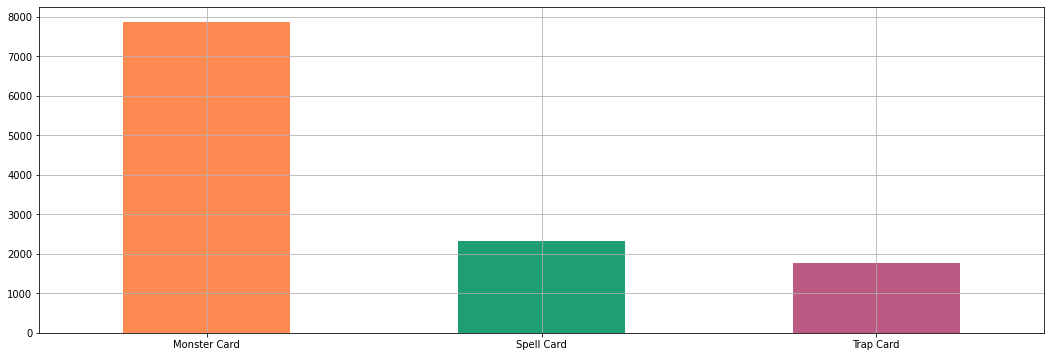

In [16]:
card_type_colors = [card_colors[i] for i in formatted_full_df['Card type'].value_counts().index]
formatted_full_df['Card type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = card_type_colors)
plt.show()

## Monsters

### Attributes

In [17]:
print('Total number of attributes:', formatted_monster_df['Attribute'].nunique())

Total number of attributes: 7


In [18]:
formatted_monster_df.drop(columns=['Card type']).groupby('Attribute').nunique()

,Name,Password,Primary type,Secondary type,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Attribute,,,,,,,,,,,,,,,,,,
DARK,2179,2143,7,6,23,14,70,63,12,6,39,152,440,3,3,7,7,2172
DIVINE,6,0,1,0,2,2,3,3,0,0,0,6,3,1,3,2,2,7
EARTH,1846,1826,7,6,23,12,71,59,11,4,29,125,316,3,3,5,6,1842
FIRE,647,643,8,6,22,12,43,40,8,4,20,82,179,3,3,3,6,645
LIGHT,1601,1566,7,6,23,14,58,50,10,5,30,129,374,3,3,7,6,1593
WATER,815,807,7,6,22,11,56,41,9,4,16,90,196,3,3,7,6,815
WIND,755,746,7,6,23,12,47,39,11,4,14,103,209,3,3,6,6,750


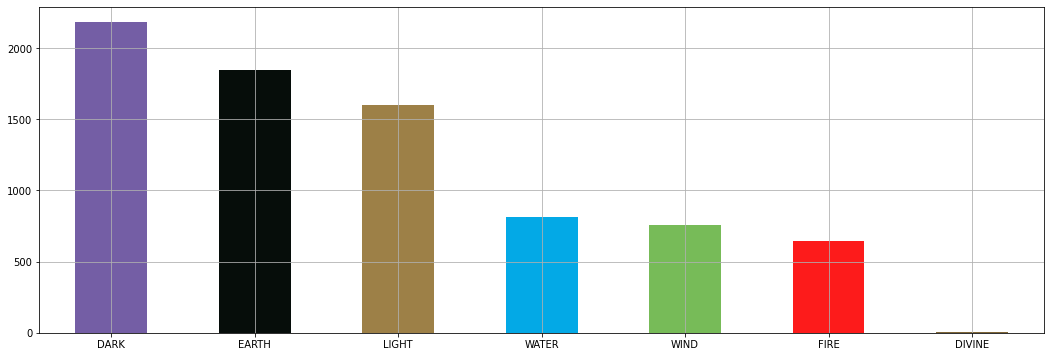

In [19]:
attribute_colors = [card_colors[i] for i in formatted_full_df['Attribute'].value_counts().index]
formatted_monster_df['Attribute'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=0, color = attribute_colors)
plt.show()

### Primary types

In [20]:
print('Total number of primary types:', formatted_monster_df['Primary type'].nunique())

Total number of primary types: 8


In [21]:
formatted_monster_df.drop(columns=['Card type']).groupby('Primary type').nunique()

,Name,Password,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Primary type,,,,,,,,,,,,,,,,,,
Effect Monster,5339,5285,6,7,25,12,74,67,13,0,0,203,748,3,3,6,6,5303
Fusion Monster,417,414,1,6,23,12,48,46,3,0,0,65,137,3,3,4,5,417
Link Monster,360,353,0,6,23,0,38,0,0,6,60,50,136,3,2,4,5,360
Monster Token,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,1
Normal Monster,744,700,1,6,23,10,59,49,10,0,0,6,128,3,3,4,4,745
Ritual Monster,115,115,2,6,15,12,33,26,1,0,0,31,36,2,3,2,1,115
Synchro Monster,400,395,1,6,23,13,40,38,4,0,0,55,151,2,3,5,5,399
Xyz Monster,477,469,0,6,23,14,51,42,4,0,0,66,186,3,2,4,5,475


#### Has effect discrimination

In [22]:
has_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].notna()).value_counts().rename('Effect')
no_effect = formatted_monster_df['Primary type'].where(formatted_monster_df['Effect type'].isna()).value_counts().rename('No Effect')
effect = pd.concat([has_effect,no_effect], axis=1)
effect

,Effect,No Effect
Effect Monster,5338.0,1
Xyz Monster,475.0,2
Synchro Monster,397.0,3
Fusion Monster,355.0,62
Link Monster,355.0,5
Ritual Monster,99.0,16
Normal Monster,34.0,711
Monster Token,NaN,1


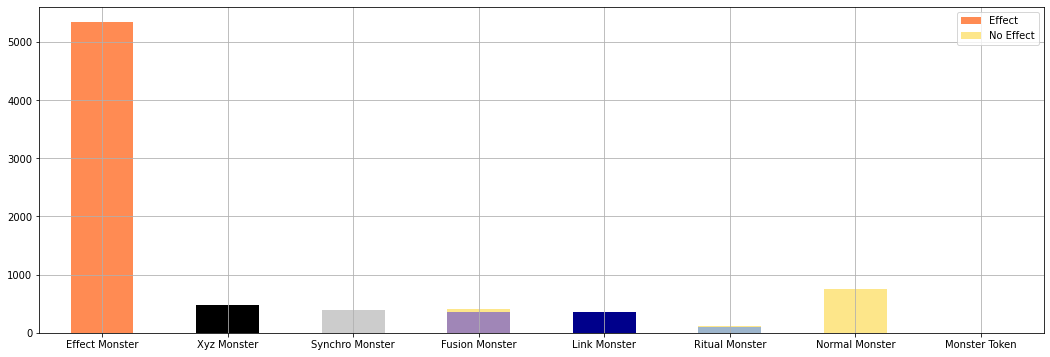

In [23]:
monster_type_colors = {'No Effect': card_colors['Normal Monster'], 'Effect': [card_colors[i] for i in effect.index]}
effect.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0,  legend=True, color = monster_type_colors)
plt.show()

Normal monster can have effect if it is pendulum

#### Is pendulum discrimination

In [24]:
not_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].isna()).value_counts().rename('Not Pendulum')
is_pendulum = formatted_monster_df['Primary type'].where(formatted_monster_df['Pendulum Scale'].notna()).value_counts().rename('Pendulum')
pendulum = pd.concat([not_pendulum,is_pendulum], axis=1)
pendulum

,Not Pendulum,Pendulum
Effect Monster,5079,260.0
Normal Monster,707,38.0
Xyz Monster,470,7.0
Fusion Monster,408,9.0
Synchro Monster,395,5.0
Link Monster,360,NaN
Ritual Monster,114,1.0
Monster Token,1,NaN


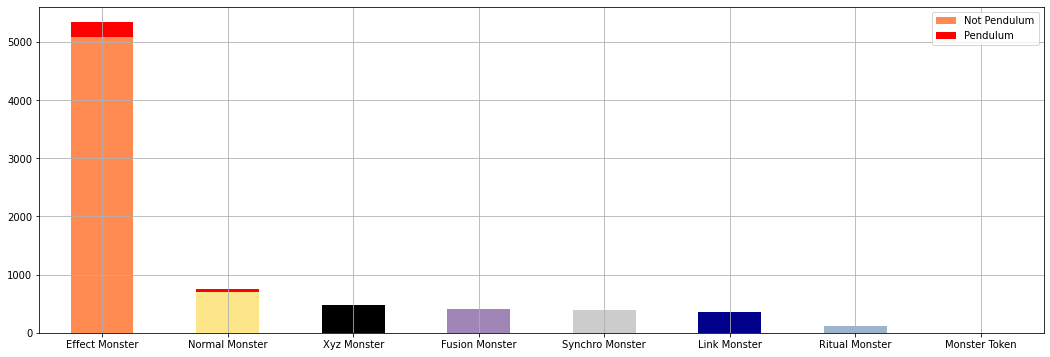

In [25]:
monster_type_colors_b = {'Pendulum': card_colors['Pendulum Monster'], 'Not Pendulum': [card_colors[i] for i in pendulum.index]}
pendulum.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = monster_type_colors_b, legend=True)
plt.show()

#### By attribute

In [26]:
primmary_crosstab = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Attribute'])
primmary_crosstab

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Primary type,,,,,,,
Effect Monster,1471,6,1282,436,1083,539,522
Fusion Monster,141,0,79,34,96,34,33
Link Monster,116,0,74,31,86,28,25
Monster Token,0,0,0,1,0,0,0
Normal Monster,186,0,250,52,81,109,67
Ritual Monster,34,0,17,7,32,19,6
Synchro Monster,104,0,67,50,74,32,73
Xyz Monster,130,0,79,36,149,54,29


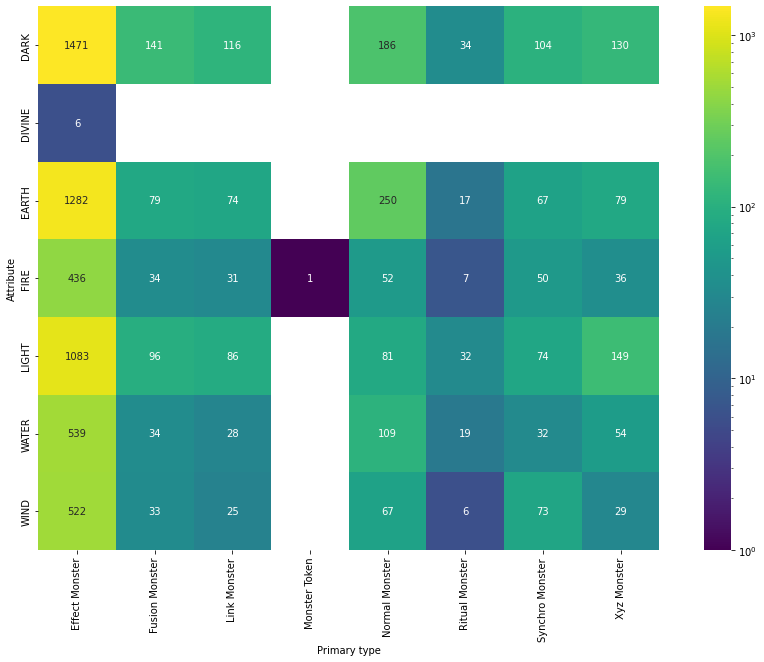

In [27]:
plt.figure(figsize = (16,10))
sns.heatmap(primmary_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Secondary types

In [28]:
print('Total number of secondary types:', formatted_monster_df['Secondary type'].nunique())

Total number of secondary types: 6


In [29]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Secondary type').nunique()

,Name,Password,Primary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Secondary type,,,,,,,,,,,,,,,,
Flip monster,180,179,1,6,19,12,38,33,1,18,44,2,3,3,4,180
Gemini monster,45,45,1,6,18,8,17,19,0,6,13,0,3,1,1,45
Spirit monster,36,36,2,6,13,9,22,20,2,7,4,1,1,2,2,36
Toon monster,17,17,1,6,7,5,12,15,0,8,13,1,2,1,2,17
Tuner monster,457,453,5,6,23,9,32,32,7,56,128,3,3,3,5,456
Union monster,37,37,1,6,9,8,17,14,0,6,9,1,2,1,1,37


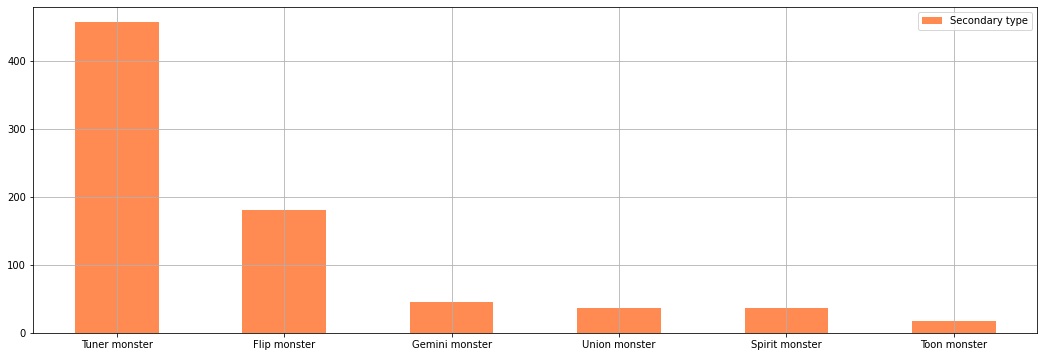

In [30]:
secondary_type_colors = card_colors['Effect Monster']
formatted_monster_df['Secondary type'].value_counts().plot.bar(figsize = (18,6), stacked = True, grid = True, rot=0, color = secondary_type_colors, legend=True)
plt.show()

#### By attribute

In [31]:
secondary_crosstab = pd.crosstab(formatted_full_df['Secondary type'],formatted_full_df['Attribute'])
secondary_crosstab

Attribute,DARK,EARTH,FIRE,LIGHT,WATER,WIND
Secondary type,,,,,,
Flip monster,50,60,9,31,13,17
Gemini monster,11,8,8,6,8,4
Spirit monster,5,6,6,4,6,9
Toon monster,7,5,1,2,1,1
Tuner monster,118,91,42,90,48,68
Union monster,6,9,3,12,4,3


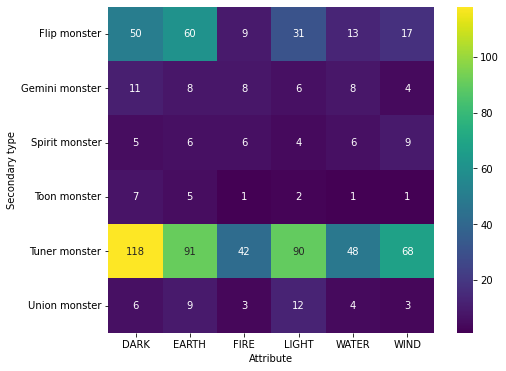

In [32]:
plt.figure(figsize = (8,6))
sns.heatmap(secondary_crosstab, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By secondary type

In [33]:
secondary_crosstab_b = pd.crosstab(formatted_full_df['Primary type'],formatted_full_df['Secondary type'], margins = True)
secondary_crosstab_b

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster,All
Primary type,,,,,,,
Effect Monster,180,45,34,17,412,37,725
Fusion Monster,0,0,0,0,3,0,3
Normal Monster,0,0,0,0,12,0,12
Ritual Monster,0,0,2,0,1,0,3
Synchro Monster,0,0,0,0,29,0,29
All,180,45,36,17,457,37,772


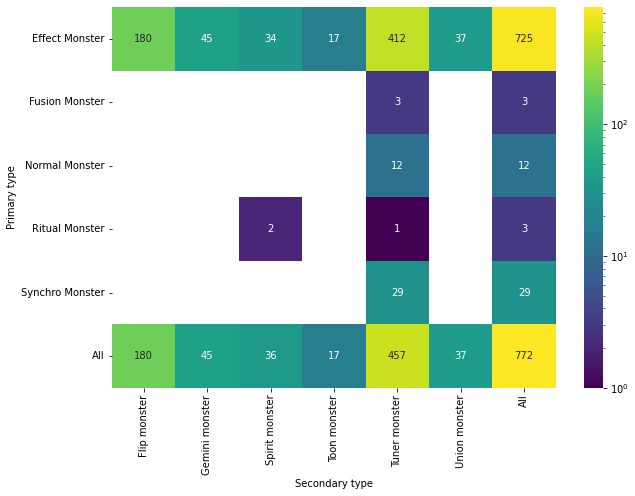

In [34]:
plt.figure(figsize = (10,7))
sns.heatmap(secondary_crosstab_b, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

### Monster types

In [35]:
print('Total number of monster types:', formatted_monster_df['Monster type'].nunique())

Total number of monster types: 25


In [36]:
formatted_monster_df.drop(columns=['Card type']).groupby('Monster type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Monster type,,,,,,,,,,,,,,,,,,
Aqua,255,251,7,6,6,10,50,33,3,2,3,51,64,2,3,3,4,255
Beast,372,365,7,4,6,10,48,38,7,2,7,59,80,3,3,4,5,373
Beast-Warrior,235,230,7,3,6,10,36,29,6,3,7,58,47,3,3,4,6,234
Creator God,1,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0,1,1
Cyberse,244,242,7,1,6,10,30,29,1,6,37,45,33,2,2,3,4,244
Dinosaur,121,119,6,1,6,10,35,30,4,2,3,35,23,1,2,3,4,121
Divine-Beast,5,0,1,0,1,1,3,3,0,0,0,5,2,1,3,2,2,6
Dragon,652,640,7,6,6,13,52,48,9,5,19,109,181,2,3,6,6,650
Fairy,495,485,7,5,6,12,43,38,8,4,12,76,105,3,3,7,6,492


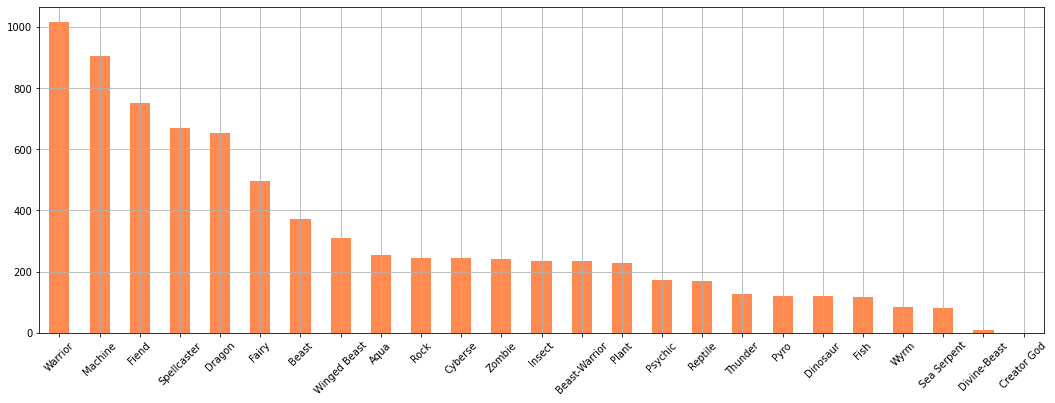

In [37]:
monster_type_colors = card_colors['Monster Card']
formatted_monster_df['Monster type'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = monster_type_colors)
plt.show()

#### By Attribute

In [38]:
monster_crosstab = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Attribute'], dropna=False)
monster_crosstab

Attribute,DARK,DIVINE,EARTH,FIRE,LIGHT,WATER,WIND
Monster type,,,,,,,
Aqua,10,0,6,10,4,219,6
Beast,36,0,211,16,72,14,24
Beast-Warrior,36,0,82,53,33,16,15
Creator God,0,1,0,0,0,0,0
Cyberse,62,0,36,43,63,28,12
Dinosaur,11,0,59,32,5,8,6
Divine-Beast,0,8,0,0,0,0,0
Dragon,252,0,47,48,164,28,113
Fairy,53,0,57,15,320,25,25


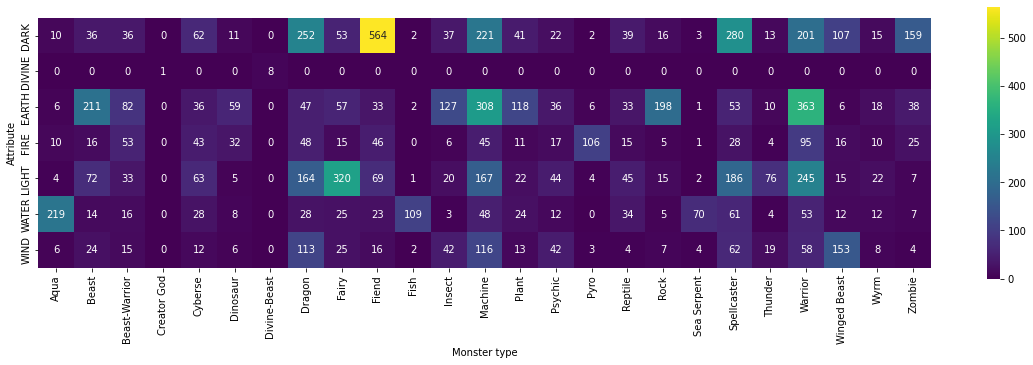

In [39]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True)
plt.show()

#### By primary type

In [40]:
monster_crosstab_b = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Primary type'], dropna=False)
monster_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Monster Token,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster
Monster type,,,,,,,,
Aqua,154,11,3,0,59,8,3,17
Beast,268,16,9,0,54,1,14,11
Beast-Warrior,161,11,9,0,21,2,8,23
Creator God,1,0,0,0,0,0,0,0
Cyberse,122,4,92,0,7,6,5,8
Dinosaur,86,7,3,0,18,0,4,3
Divine-Beast,5,0,0,0,0,0,0,0
Dragon,346,62,33,0,45,15,93,58
Fairy,357,20,24,0,36,15,17,26


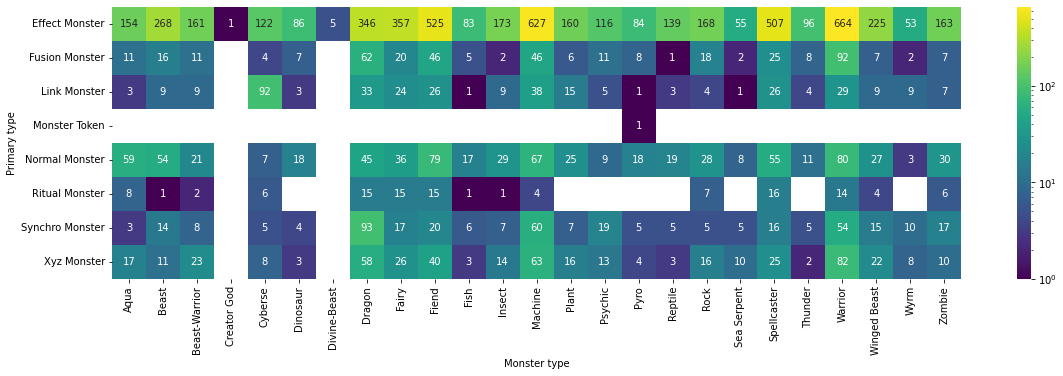

In [41]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

#### By secondary type

In [42]:
monster_crosstab_c = pd.crosstab(formatted_full_df['Monster type'],formatted_full_df['Secondary type'], dropna=False)
monster_crosstab_c

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster
Monster type,,,,,,
Aqua,4,4,1,1,10,3
Beast,15,1,2,0,22,0
Beast-Warrior,1,0,1,0,9,0
Cyberse,0,0,0,0,6,0
Dinosaur,0,0,0,0,7,0
Dragon,1,6,1,3,42,4
Fairy,6,2,7,0,20,5
Fiend,27,4,2,1,41,1
Fish,0,1,0,0,5,0


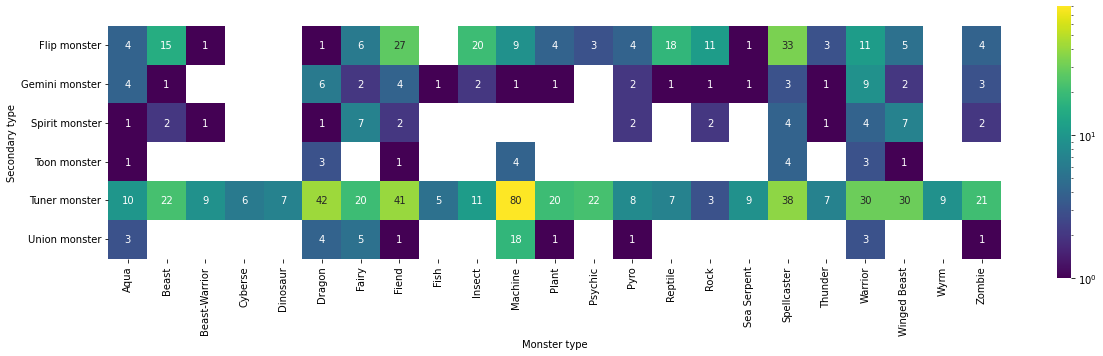

In [43]:
plt.figure(figsize = (20,5))
sns.heatmap(monster_crosstab_c.T, annot=True, fmt="g", cmap='viridis', square=True, norm = LogNorm())
plt.show()

### Effect type

In [44]:
print('Total number of effect types:', formatted_monster_df['Effect type'].explode().nunique())

Total number of effect types: 14


In [45]:
formatted_monster_df[formatted_monster_df['Effect type'].notna()].drop(columns=['Card type']).explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Effect type,,,,,,,,,,,,,,,,,,
Activation condition,1,1,1,0,1,1,1,1,1,1,0,0,1,0,0,1,1,1
Condition,2938,2876,7,6,7,25,14,63,63,13,5,52,609,3,3,5,6,2917
Continuous Effect,2109,2093,6,5,7,24,14,59,52,12,6,48,541,3,3,4,4,2107
Continuous-like Effect,233,233,6,3,6,21,11,42,36,13,1,2,72,2,3,3,2,233
Flip effect,169,168,1,1,6,19,12,38,33,1,0,0,42,2,3,3,4,169
Ignition Effect,2542,2517,6,6,7,24,13,66,61,12,5,42,618,3,3,5,6,2528
Ignition-like Effect,214,205,6,2,6,20,12,35,32,13,1,1,73,1,3,3,5,214
Lingering effect,16,16,2,1,6,11,7,11,13,0,2,2,9,0,0,2,1,16
Maintenance cost,44,44,3,0,6,12,8,21,18,2,1,1,8,0,1,1,1,44


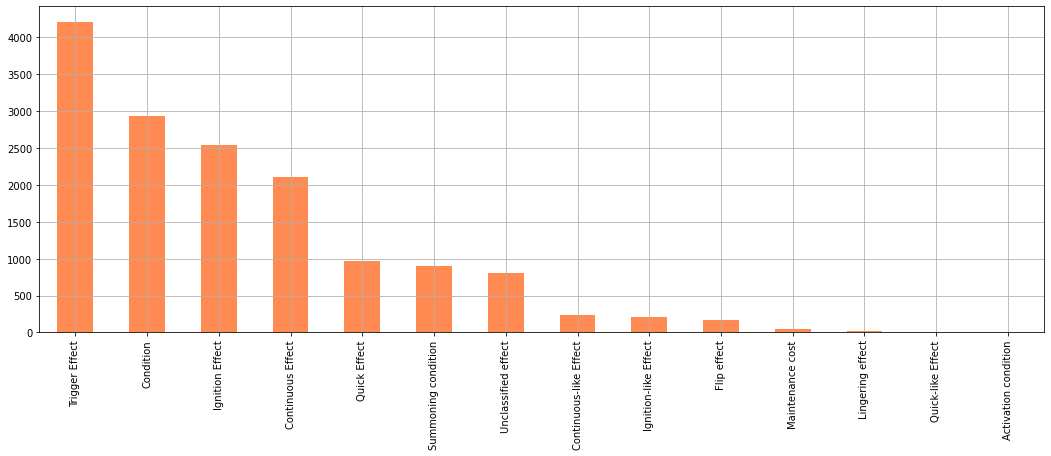

In [46]:
monster_effect_colors = card_colors['Effect Monster']
formatted_monster_df['Effect type'].explode('Effect type').value_counts().plot.bar(figsize = (18,6), grid = True, color = monster_effect_colors)
plt.show()

### ATK

In [47]:
print('Total number of ATK values:', formatted_monster_df['ATK'].nunique())

Total number of ATK values: 83


In [48]:
formatted_monster_df.drop(columns=['Card type']).groupby('ATK').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
ATK,,,,,,,,,,,,,,,,,,
0,600,574,8,5,6,23,13,35,9,5,15,89,228,3,3,6,6,598
50,2,2,1,0,2,2,1,2,0,0,0,2,2,0,0,1,1,2
100,214,213,5,3,6,20,11,27,8,2,2,48,105,2,3,2,3,214
150,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1
200,114,114,6,5,6,20,7,21,4,1,2,34,65,2,3,2,3,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,2,2,1,0,2,1,1,1,0,0,0,2,1,0,0,1,1,2
5000,9,9,5,0,3,4,2,4,0,1,1,8,6,1,1,1,1,9
?,83,74,6,1,7,20,15,8,2,1,1,34,35,2,3,5,4,83


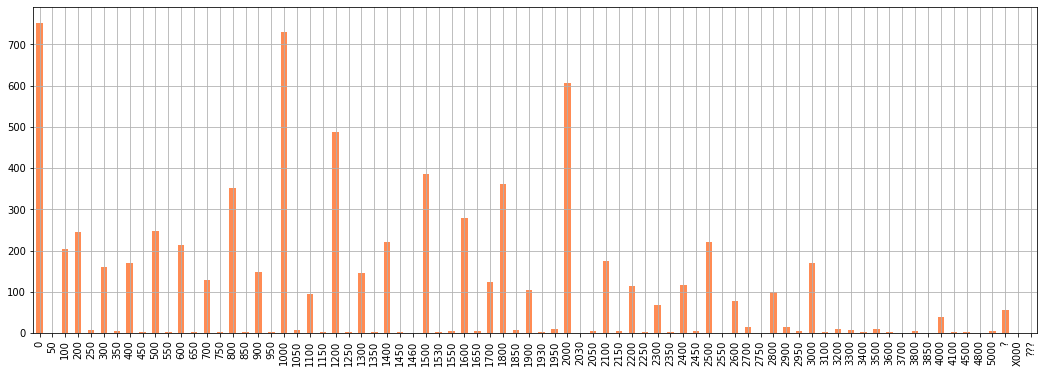

In [49]:
atk_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = atk_colors)
plt.show()

### DEF

In [50]:
print('Total number of DEF values:', formatted_monster_df['DEF'].nunique())

Total number of DEF values: 78


In [51]:
formatted_monster_df.drop(columns=['Card type']).groupby('DEF').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
DEF,,,,,,,,,,,,,,,,,,
0,753,723,7,6,6,23,14,45,10,0,0,101,252,3,3,5,5,750
50,1,1,1,0,1,1,1,1,0,0,0,1,1,0,0,1,1,1
100,204,203,5,4,6,19,10,24,8,0,0,45,92,2,3,3,3,203
200,246,244,5,5,6,23,10,31,5,0,0,47,105,3,3,3,5,246
250,8,8,2,1,4,5,2,4,0,0,0,5,3,0,1,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,1,1,1,0,1,1,1,1,0,0,0,1,1,0,0,1,1,1
5000,5,5,2,0,3,3,2,2,0,0,0,4,3,1,1,1,1,5
?,56,49,5,1,7,17,14,2,1,0,0,25,25,2,3,4,4,56


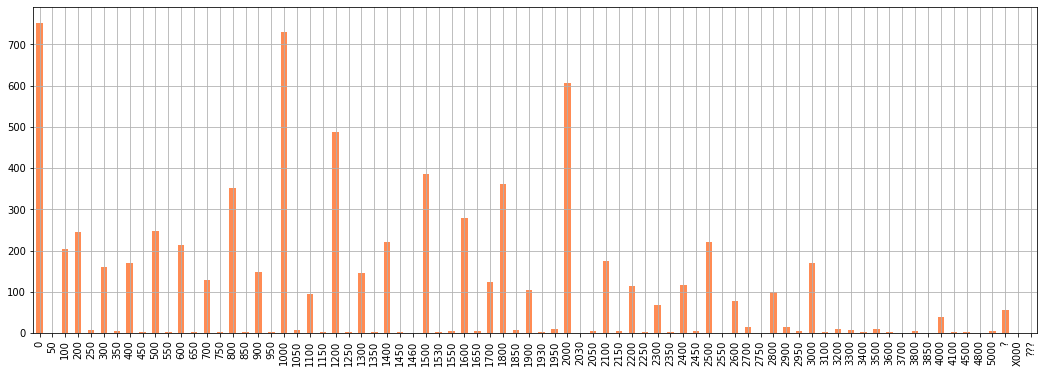

In [52]:
def_colors = card_colors['Monster Card']
formatted_monster_df['DEF'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, color = def_colors)
plt.show()

### Level/Rank

In [53]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Level/Rank').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,ATK,DEF,Pendulum Scale,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Level/Rank,,,,,,,,,,,,,,,,
0,6,6,2,0,2,2,3,3,0,5,3,0,0,2,2,6
1,622,596,7,5,6,23,22,29,10,79,223,3,3,4,5,620
2,659,648,6,5,6,23,30,30,7,71,207,2,3,5,6,658
3,1135,1129,6,5,6,23,41,36,9,92,286,3,3,4,7,1135
4,2310,2298,6,6,6,23,54,47,9,134,493,3,3,5,7,2302
5,589,588,6,6,6,23,46,38,8,83,232,3,3,4,3,589
6,594,586,6,6,6,23,38,38,9,90,229,3,3,6,6,594
7,459,450,6,6,6,23,36,35,9,99,218,3,3,5,6,461
8,655,637,6,5,6,23,42,41,8,111,295,3,3,5,5,657


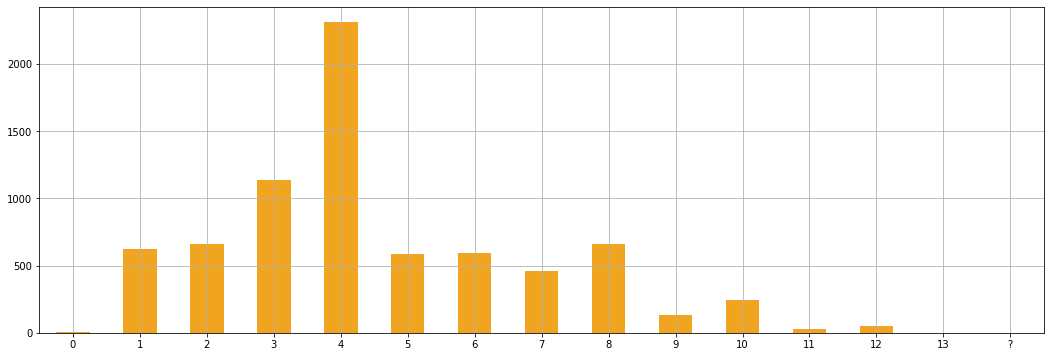

In [54]:
stars_colors = card_colors['Level']
formatted_monster_df['Level/Rank'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color= stars_colors)
plt.show()

#### ATK statistics

In [55]:
formatted_monster_df[['Level/Rank','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

ATK                                                         \
             count         mean          std  min     25%     50%     75%   
Level/Rank                                                                  
0              5.0   600.000000  1341.640786  0.0     0.0     0.0     0.0   
1            612.0   240.604575   353.260419  0.0     0.0   100.0   300.0   
2            656.0   584.908537   403.601335  0.0   300.0   500.0   800.0   
3           1132.0   960.733216   483.962143  0.0   600.0  1000.0  1300.0   
4           2298.0  1417.941688   541.259260  0.0  1200.0  1500.0  1800.0   
5            586.0  1763.344710   638.406194  0.0  1500.0  1900.0  2200.0   
6            591.0  2015.143824   612.416667  0.0  1900.0  2200.0  2400.0   
7            455.0  2292.197802   610.246217  0.0  2200.0  2500.0  2600.0   
8            647.0  2550.927357   703.292174  0.0  2500.0  2800.0  3000.0   
9            132.0  2602.651515   854.452067  0.0  2500.0  2800.0  3000.0   
10           223.0  2823.542601  1222.294588  0.0  2800.0  3000.0  3500.0   
11            30.0  2990.000000  1093.113238  0.0  3000.0  3350.0  3500.0   
12            45.0  3355.555556  1429.964328  0.0  3000.0  4000.0  4000.0   

                    
               max  
Level/Rank          
0           3000.0  
1           2500.0  
2           2400.0  
3           3000.0  
4           3000.0  
5           4000.0  
6           4000.0  
7           3300.0  
8           4500.0  
9           4500.0  
10          5000.0  
11          4000.0  
12          5000.0

#### DEF statistics

In [56]:
formatted_monster_df[['Level/Rank','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Level/Rank').describe()

DEF                                                         \
             count         mean          std  min     25%     50%     75%   
Level/Rank                                                                  
0              5.0   400.000000   894.427191  0.0     0.0     0.0     0.0   
1            614.0   339.983713   520.980535  0.0     0.0   100.0   400.0   
2            657.0   657.610350   551.711511  0.0   200.0   500.0   900.0   
3           1132.0   953.710247   569.517003  0.0   600.0   900.0  1300.0   
4           2300.0  1168.839130   606.491131  0.0   800.0  1200.0  1600.0   
5            587.0  1425.724020   671.433654  0.0  1000.0  1500.0  1900.0   
6            591.0  1563.333333   705.715568  0.0  1200.0  1700.0  2000.0   
7            457.0  1879.868709   651.415113  0.0  1600.0  2000.0  2300.0   
8            654.0  1979.663609   842.050955  0.0  1600.0  2100.0  2500.0   
9            132.0  2291.287879   805.953426  0.0  2000.0  2500.0  2925.0   
10           232.0  2232.543103  1284.231371  0.0  1900.0  2500.0  3000.0   
11            30.0  2661.666667  1169.415071  0.0  2125.0  3000.0  3400.0   
12            46.0  2852.173913  1672.089728  0.0  2000.0  3350.0  4000.0   

                    
               max  
Level/Rank          
0           2000.0  
1           2500.0  
2           2400.0  
3           3000.0  
4           3000.0  
5           3000.0  
6           3000.0  
7           3300.0  
8           4000.0  
9           3700.0  
10          5000.0  
11          4000.0  
12          5000.0

### Pendulum scale

In [57]:
formatted_monster_df.drop(columns=['Card type', 'Link', 'Link Arrows']).groupby('Pendulum Scale').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Pendulum Scale,,,,,,,,,,,,,,,,
0,10,10,2,1,5,7,6,5,5,8,8,1,0,1,1,10
1,67,64,5,2,6,10,11,28,26,37,38,0,1,3,4,67
2,36,35,2,1,6,11,6,17,22,21,15,0,2,3,3,36
3,36,36,2,1,6,15,8,22,15,23,17,0,0,1,1,36
4,32,32,5,0,5,8,8,18,16,25,16,1,1,1,1,32
5,34,34,2,1,6,12,7,23,21,20,16,0,1,3,3,34
6,15,14,1,1,4,7,6,11,11,11,9,0,0,1,2,15
7,27,26,2,1,6,14,6,19,17,14,16,0,2,1,2,27
8,39,39,5,1,6,9,8,19,18,23,21,0,0,1,2,39


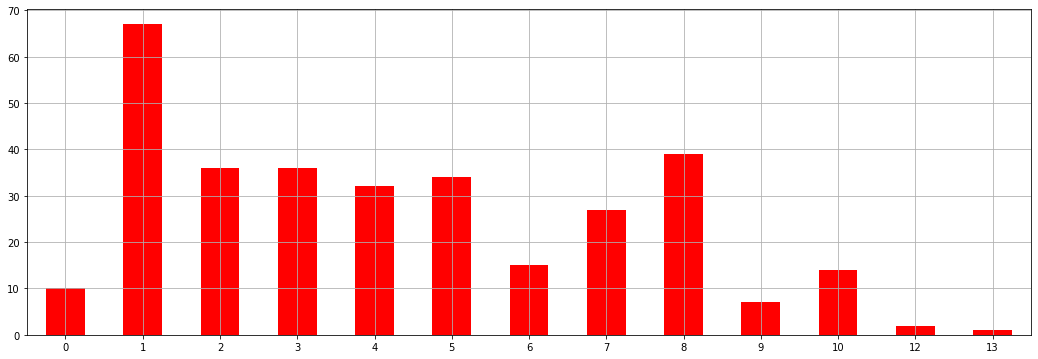

In [58]:
scales_colors = card_colors['Pendulum Monster']
formatted_monster_df['Pendulum Scale'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = scales_colors)
plt.show()

#### ATK statistics

In [59]:
formatted_monster_df[['Pendulum Scale','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

ATK                                                    \
               count         mean          std     min     25%     50%   
Pendulum Scale                                                           
0               10.0  1390.000000  1317.784336     0.0     0.0  1450.0   
1               66.0  1751.515152  1053.381723     0.0  1000.0  1800.0   
2               36.0  1423.611111   688.734462   100.0   800.0  1500.0   
3               36.0  1437.500000   845.354955     0.0   600.0  1725.0   
4               32.0  1787.500000  1011.785391     0.0  1100.0  2000.0   
5               34.0  1339.705882   808.831875     0.0   850.0  1325.0   
6               15.0  1320.000000   707.308783   100.0   950.0  1500.0   
7               27.0  1279.629630   787.920737     0.0   700.0  1400.0   
8               39.0  1225.641026   968.644726     0.0   300.0  1200.0   
9                7.0  2114.285714   781.938982  1000.0  1700.0  2400.0   
10              14.0  1678.571429  1376.829452     0.0   125.0  2500.0   
12               1.0   100.000000          NaN   100.0   100.0   100.0   
13               1.0     0.000000          NaN     0.0     0.0     0.0   

                                
                   75%     max  
Pendulum Scale                  
0               2500.0  3000.0  
1               2500.0  4000.0  
2               2000.0  2500.0  
3               2025.0  2600.0  
4               2550.0  3000.0  
5               1800.0  3450.0  
6               1800.0  2400.0  
7               1750.0  3000.0  
8               2000.0  3300.0  
9               2600.0  2800.0  
10              2875.0  3000.0  
12               100.0   100.0  
13                 0.0     0.0

#### DEF statistics

In [60]:
formatted_monster_df[['Pendulum Scale','DEF']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

DEF                                                    \
               count         mean          std     min     25%     50%   
Pendulum Scale                                                           
0               10.0  1200.000000  1273.664878     0.0     0.0   750.0   
1               67.0  1571.641791   940.310389     0.0   950.0  1700.0   
2               36.0  1338.888889   728.316171     0.0   875.0  1200.0   
3               36.0  1165.277778   788.834533     0.0   575.0  1200.0   
4               32.0  1534.375000   830.316448     0.0  1000.0  1600.0   
5               34.0  1136.764706   822.625953     0.0   550.0  1000.0   
6               15.0  1226.666667   711.604492   400.0   600.0  1100.0   
7               27.0  1312.962963   830.383669     0.0   700.0  1300.0   
8               39.0  1015.384615   789.916205     0.0   350.0  1000.0   
9                7.0  1257.142857   680.336051  1000.0  1000.0  1000.0   
10              14.0  1850.000000  1124.380171     0.0   750.0  2500.0   
12               1.0   100.000000          NaN   100.0   100.0   100.0   
13               1.0     0.000000          NaN     0.0     0.0     0.0   

                                
                   75%     max  
Pendulum Scale                  
0               2500.0  3000.0  
1               2350.0  4000.0  
2               1825.0  2700.0  
3               1800.0  3000.0  
4               2075.0  2800.0  
5               1575.0  3000.0  
6               1700.0  2600.0  
7               2000.0  2700.0  
8               1700.0  2700.0  
9               1000.0  2800.0  
10              2575.0  3000.0  
12               100.0   100.0  
13                 0.0     0.0

#### Level/Rank statistics

In [61]:
formatted_monster_df[['Pendulum Scale','Level/Rank']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Pendulum Scale').describe()

Level/Rank                                                
                    count      mean       std  min   25%  50%   75%   max
Pendulum Scale                                                           
0                    10.0  6.100000  3.348300  1.0  3.75  7.0  8.00  10.0
1                    67.0  5.955224  2.427324  1.0  4.00  6.0  8.00  12.0
2                    36.0  4.416667  1.380993  1.0  3.75  4.0  5.00   7.0
3                    36.0  4.444444  1.731134  1.0  4.00  4.0  5.00  10.0
4                    32.0  5.562500  2.154328  1.0  4.00  6.0  7.00   8.0
5                    34.0  4.176471  1.961301  1.0  3.00  4.0  4.00  11.0
6                    15.0  3.933333  1.579632  1.0  3.00  4.0  4.50   8.0
7                    27.0  4.185185  1.641693  2.0  3.00  4.0  5.00  10.0
8                    39.0  3.923077  2.355113  1.0  2.00  4.0  6.00  10.0
9                     7.0  5.714286  1.380131  4.0  5.00  5.0  6.50   8.0
10                   14.0  6.714286  2.812843  1.0  7.00  7.0  7.75  10.0
12                    2.0  6.500000  7.778175  1.0  3.75  6.5  9.25  12.0
13                    1.0  7.000000       NaN  7.0  7.00  7.0  7.00   7.0

### Link

In [62]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Secondary type','Level/Rank','DEF','Pendulum Scale']).groupby('Link').nunique().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce'))

,Name,Password,Attribute,Monster type,ATK,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Link,,,,,,,,,,,,,
1,47,47,6,11,10,8,18,25,1,0,3,3,47
2,180,179,6,23,23,18,31,100,1,2,3,4,180
3,81,81,6,16,17,17,25,46,2,1,2,2,81
4,43,40,6,15,12,13,20,24,2,0,3,4,43
5,8,5,2,5,4,3,5,4,0,0,2,2,8
6,1,1,1,1,1,1,1,1,0,0,1,1,1


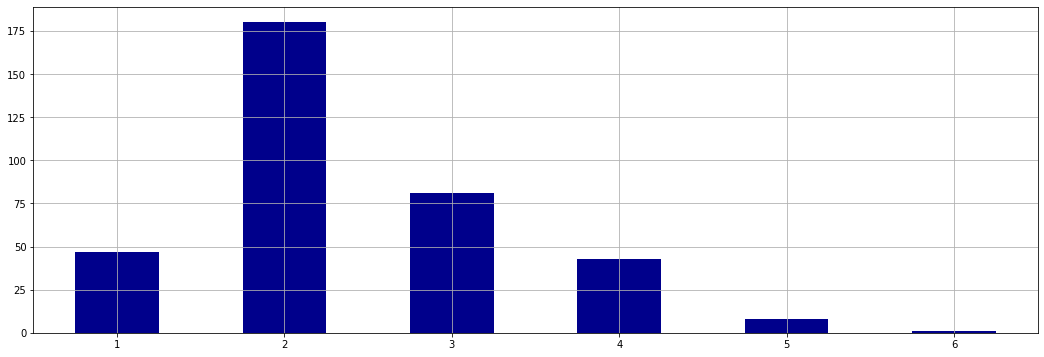

In [63]:
link_colors = card_colors['Link Monster']
formatted_monster_df['Link'].value_counts().sort_index(key=lambda x: pd.to_numeric(x, errors = 'coerce')).plot.bar(figsize = (18,6), grid = True, rot=0, color = link_colors)
plt.show()

#### ATK statistics

In [64]:
formatted_monster_df[['Link','ATK']].apply(pd.to_numeric, errors = 'coerce').dropna().astype(int).groupby('Link').describe()

ATK                                                                 
      count         mean         std     min     25%     50%     75%     max
Link                                                                        
1      47.0   736.170213  482.937358     0.0   400.0   800.0  1000.0  1500.0
2     180.0  1401.388889  512.672659     0.0  1100.0  1500.0  1800.0  2300.0
3      81.0  2258.641975  659.487970     0.0  2200.0  2400.0  2500.0  4000.0
4      42.0  2664.285714  661.418073     0.0  2525.0  2800.0  3000.0  3300.0
5       8.0  3250.000000  755.928946  2500.0  3000.0  3000.0  3125.0  5000.0
6       1.0     0.000000         NaN     0.0     0.0     0.0     0.0     0.0

### Link Arrows

#### By combination

In [65]:
print('Total number of link arrow combinations:', formatted_monster_df['Link Arrows'].nunique())

Total number of link arrow combinations: 60


In [66]:
formatted_monster_df.drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Link', 'Secondary type', 'DEF']).groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,,,,
"(←,)",5,5,2,3,2,4,4,0,0,3,2,5
"(←, ↑)",4,4,2,3,4,3,2,0,0,1,1,4
"(←, →)",18,18,6,8,11,8,9,0,0,2,2,18
"(←, →, ↑)",7,7,3,5,6,6,5,0,0,1,1,7
"(↑,)",10,10,5,5,6,9,5,0,0,1,1,10
"(↑, ↖, ↗)",2,2,2,2,2,1,1,0,0,1,1,2
"(→,)",2,2,2,2,1,2,1,0,0,1,1,2
"(→, ↑)",2,2,2,2,2,1,1,0,0,1,1,2
"(↓,)",18,18,5,7,9,10,14,0,0,2,3,18


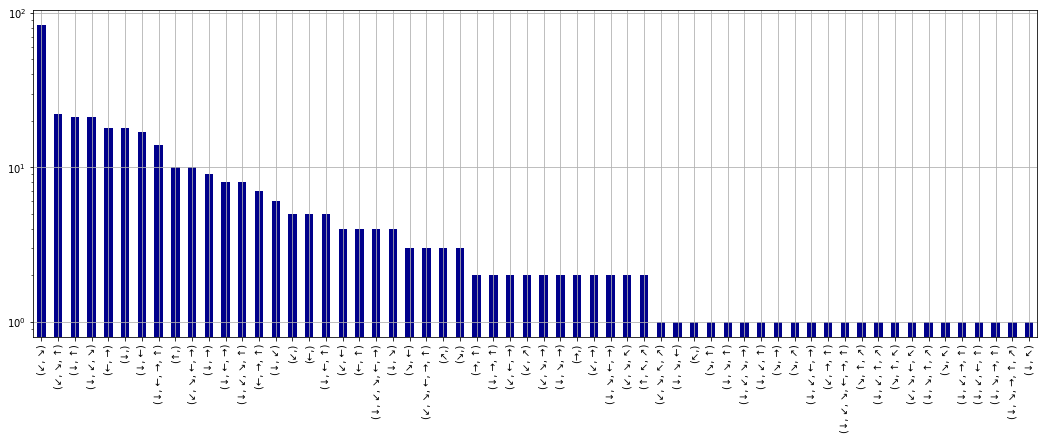

In [67]:
arrows_colors = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].value_counts().plot.bar(figsize = (18,6), logy=True, grid = True, color = arrows_colors)
plt.show()

#### By unique

In [68]:
formatted_monster_df[formatted_monster_df['Link Arrows'].notna()].drop(columns=['Card type', 'Primary type', 'Level/Rank', 'Pendulum Scale', 'Secondary type', 'DEF']).explode('Link Arrows').groupby('Link Arrows').nunique()

,Name,Password,Attribute,Monster type,ATK,Link,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Link Arrows,,,,,,,,,,,,,
←,111,105,6,20,29,6,33,44,2,0,4,3,111
↑,113,110,6,18,27,6,30,44,2,1,3,4,113
→,97,91,6,18,27,6,28,40,2,0,3,3,97
↓,154,147,6,19,31,6,40,66,3,0,3,5,154
↖,10,10,5,5,9,4,6,5,1,0,1,2,10
↗,13,13,5,6,9,5,6,6,0,0,1,2,13
↘,184,180,6,22,32,6,35,101,3,2,4,5,184
↙,186,183,6,22,33,6,37,102,3,2,4,4,186


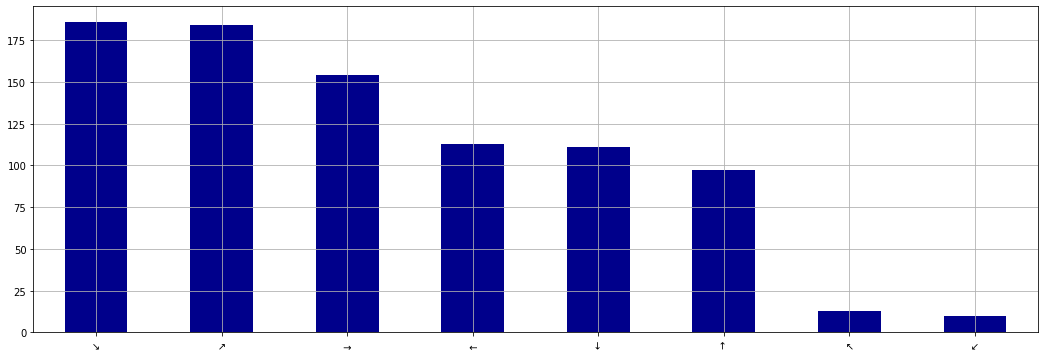

In [69]:
arrows_colors_b = card_colors['Link Monster']
formatted_monster_df['Link Arrows'].explode('Link Arrows').value_counts().plot.bar(figsize = (18,6), grid = True, color = arrows_colors_b)
plt.show()

#### By link

In [70]:
arrow_per_link = formatted_monster_df[['Link Arrows','Link']].explode('Link Arrows').dropna()
arrow_crosstab = pd.crosstab(arrow_per_link['Link Arrows'],arrow_per_link['Link'])
arrow_crosstab

Link,1,2,3,4,5,6
Link Arrows,,,,,,
←,5,46,23,29,7,1
↑,10,28,43,27,4,1
→,2,32,24,30,8,1
↓,18,58,41,31,5,1
↖,1,2,5,2,0,0
↗,3,3,3,3,1,0
↘,3,94,53,25,8,1
↙,5,97,51,25,7,1


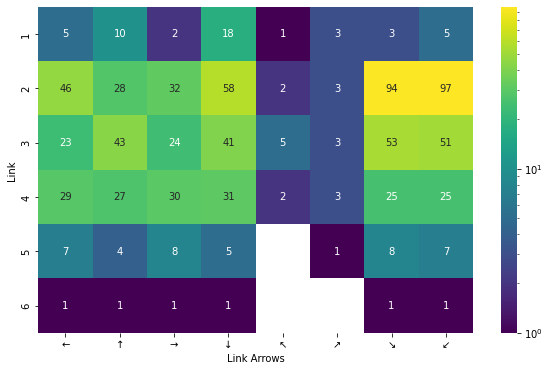

In [71]:
plt.figure(figsize = (10,6))
sns.heatmap(arrow_crosstab.T, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

## Spell & Trap

### Properties

In [72]:
print('Total number of properties:', formatted_st_df['Property'].nunique())

Total number of properties: 9


In [73]:
formatted_st_df.drop(columns=['Card type']).groupby('Property').nunique()

,Name,Password,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Property,,,,,,,,,
Continuous Spell Card,406,401,53,155,3,3,5,5,404
Continuous Trap Card,485,475,61,160,2,3,4,4,485
Counter Trap Card,153,150,17,57,2,2,2,3,153
Equip Spell Card,256,256,36,72,1,3,2,2,256
Field Spell Card,265,260,35,139,2,3,5,5,266
Normal Spell Card,902,898,43,225,3,3,4,6,903
Normal Trap Card,1139,1135,48,231,3,2,4,6,1131
Quick-Play Spell Card,410,403,32,133,3,3,3,4,409
Ritual Spell Card,72,72,8,23,2,2,1,1,72


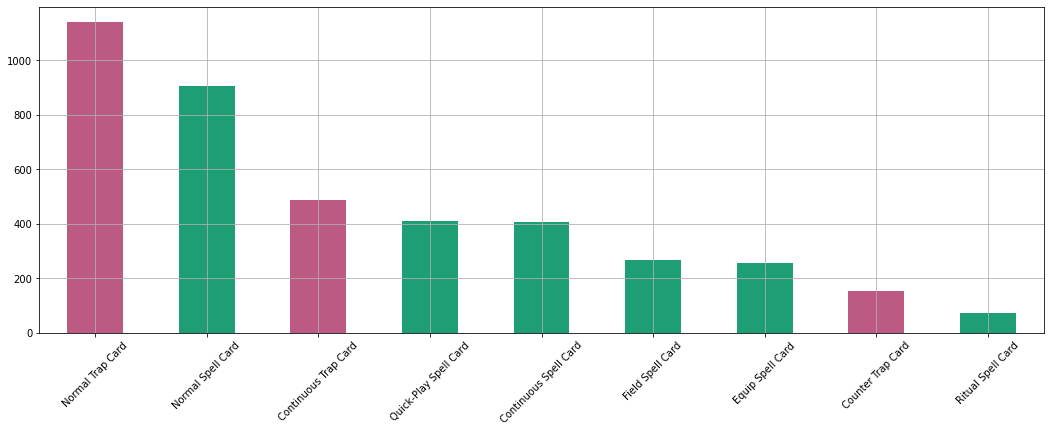

In [74]:
st_colors = [card_colors[i] for i in formatted_full_df[['Card type','Property']].value_counts().index.get_level_values(0)]
formatted_st_df['Property'].value_counts().plot.bar(figsize = (18,6), grid = True, rot=45, color = st_colors)
plt.show()

### Effect type

In [75]:
print('Total number of effect types:', formatted_st_df['Effect type'].explode().nunique())

Total number of effect types: 14


In [76]:
formatted_st_df.explode('Effect type').groupby('Effect type').nunique()

,Name,Password,Card type,Property,Archseries,Artwork,Errata,TCG status,OCG status,Modification date
Effect type,,,,,,,,,,
Activation condition,830,823,2,8,170,3,3,4,5,828
Condition,1598,1571,2,9,362,3,3,5,5,1585
Continuous Effect,19,19,2,6,11,0,2,1,1,19
Continuous-like Effect,877,866,2,7,230,3,3,5,5,877
Cost,449,447,2,7,110,3,3,4,4,449
Effect,2859,2835,2,9,418,3,3,5,6,2840
Ignition Effect,1,1,1,1,1,0,0,1,1,1
Ignition-like Effect,416,409,1,6,175,1,2,4,5,413
Lingering effect,94,94,2,6,41,2,2,3,3,94


#### Spell & Trap discrimination

In [77]:
spell = formatted_spell_df['Effect type'].explode('Effect type').value_counts().rename('Spell Card')
trap = formatted_trap_df['Effect type'].explode('Effect type').value_counts().rename('Trap Card')
st_diff = pd.concat([spell, trap], axis = 1)
st_diff

,Spell Card,Trap Card
Effect,1486.0,1374.0
Condition,1084.0,515.0
Continuous-like Effect,598.0,280.0
Trigger Effect,537.0,272.0
Ignition-like Effect,416.0,NaN
Activation condition,244.0,586.0
Cost,241.0,208.0
Unclassified effect,61.0,19.0
Lingering effect,56.0,38.0
Maintenance cost,11.0,11.0


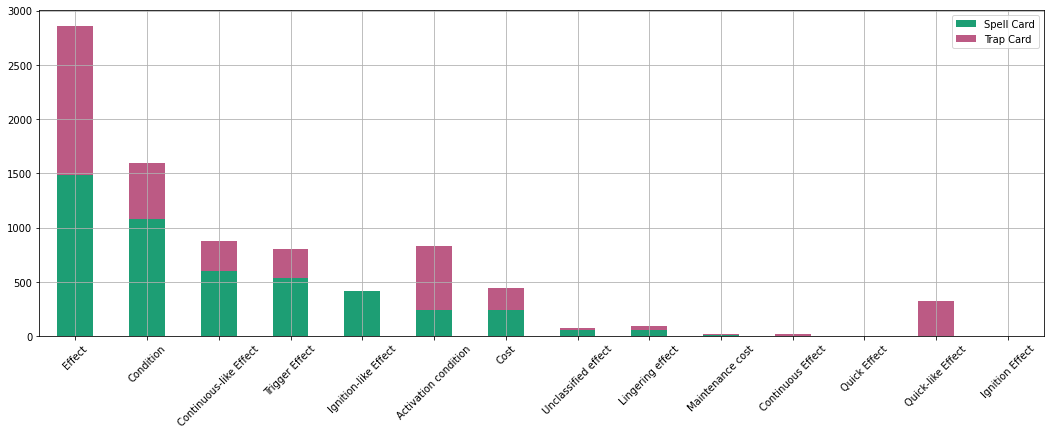

In [78]:
st_diff_colors = {'Spell Card': card_colors['Spell Card'], 'Trap Card': card_colors['Trap Card']}
st_diff.plot.bar(figsize = (18,6), stacked = True, grid = True, rot=45, color = st_diff_colors)
plt.show()

## Archseries

In [79]:
exploded_archseries = formatted_full_df.explode('Archseries')
print('Total number of Archseries:', exploded_archseries['Archseries'].nunique())

Total number of Archseries: 701


In [80]:
exploded_archseries.groupby('Archseries').nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Artwork,Errata,TCG status,OCG status,Modification date
Archseries,,,,,,,,,,,,,,,,,,,,
"""C""",8,8,1,0,2,0,1,1,7,8,8,0,0,0,6,0,1,2,1,8
-Eyes Dragon,71,71,1,0,7,2,6,3,10,16,13,6,1,1,44,1,3,2,2,71
/Assault Mode,7,7,1,0,1,0,5,6,5,6,6,0,0,0,5,0,0,1,1,7
@Ignister,18,18,1,0,6,1,6,1,7,10,9,0,3,4,9,0,0,1,1,18
A-to-Z,16,16,1,0,3,1,1,1,4,13,12,0,0,0,5,2,3,1,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sphinx,10,10,2,1,1,0,2,2,4,8,5,0,0,0,9,0,0,1,1,10
sprout,2,2,1,0,1,0,1,1,1,1,1,0,0,0,2,0,0,1,1,2
tellarknight,21,21,2,3,2,0,2,3,2,16,14,2,0,0,11,0,0,2,2,21


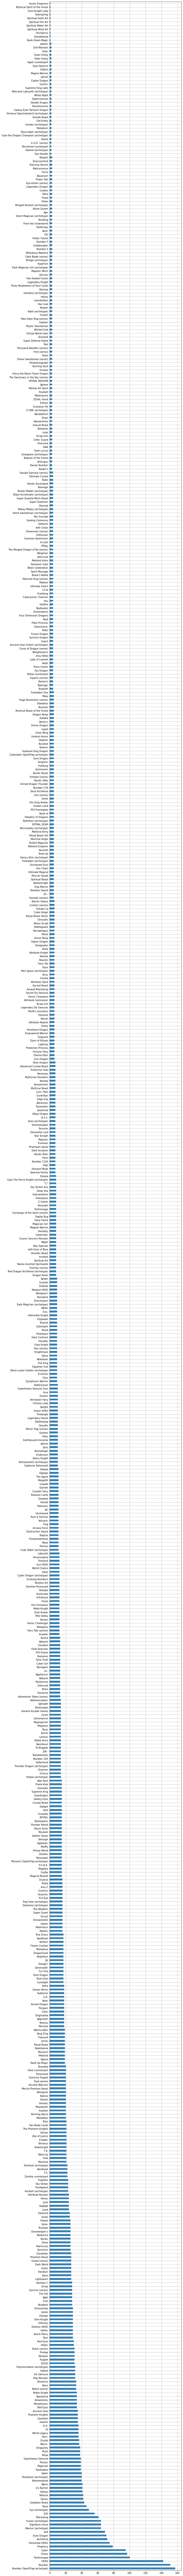

In [81]:
exploded_archseries['Archseries'].value_counts().plot.barh(figsize = (10,200), grid = True)
plt.show()

### By card type

In [82]:
archseries_crosstab = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Card type'], margins = True)
archseries_crosstab

Card type,Monster Card,Spell Card,Trap Card,All
Archseries,,,,
"""C""",8,0,0,8
-Eyes Dragon,71,0,0,71
/Assault Mode,7,0,0,7
@Ignister,18,0,0,18
A-to-Z,16,0,0,16
...,...,...,...,...
sprout,2,0,0,2
tellarknight,17,4,0,21
with Chain,0,0,4,4


### By primary type

In [83]:
archseries_crosstab_b = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Primary type'], margins = True)
archseries_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Monster Token,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster,All
Archseries,,,,,,,,,
"""C""",7,0,0,0,1,0,0,0,8
-Eyes Dragon,31,11,1,0,3,4,5,16,71
/Assault Mode,7,0,0,0,0,0,0,0,7
@Ignister,10,1,4,0,0,1,1,1,18
A-to-Z,6,8,0,0,2,0,0,0,16
...,...,...,...,...,...,...,...,...,...
sphinx,9,0,0,0,0,0,0,0,9
sprout,2,0,0,0,0,0,0,0,2
tellarknight,12,0,0,0,0,0,0,5,17


### By secondary type

In [84]:
archseries_crosstab_c = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Secondary type'], margins = True)
archseries_crosstab_c

Secondary type,Flip monster,Gemini monster,Spirit monster,Toon monster,Tuner monster,Union monster,All
Archseries,,,,,,,
-Eyes Dragon,0,2,0,2,0,0,4
@Ignister,0,0,0,0,1,0,1
A-to-Z,0,0,0,0,0,6,6
Adamancipator,0,0,0,0,3,0,3
Alien,1,1,0,0,1,0,3
...,...,...,...,...,...,...,...
itsu,0,0,0,0,0,2,2
lswarm,2,0,0,0,0,0,2
roid,0,0,0,0,9,0,9


### By monster type

In [85]:
archseries_crosstab_d = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Monster type'], margins = True)
archseries_crosstab_d

Monster type,Aqua,Beast,Beast-Warrior,Creator God,Cyberse,Dinosaur,Divine-Beast,Dragon,Fairy,Fiend,...,Reptile,Rock,Sea Serpent,Spellcaster,Thunder,Warrior,Winged Beast,Wyrm,Zombie,All
Archseries,,,,,,,,,,,,,,,,,,,,,
"""C""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
-Eyes Dragon,0,0,0,0,0,0,0,66,0,0,...,0,0,0,0,0,0,0,0,3,71
/Assault Mode,0,0,0,0,0,0,0,2,0,0,...,0,0,0,1,0,1,0,0,1,7
@Ignister,0,0,0,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
A-to-Z,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sphinx,0,3,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,9
sprout,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
tellarknight,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,15,0,1,0,17


### By property

In [86]:
archseries_crosstab_e = pd.crosstab(exploded_archseries['Archseries'],exploded_archseries['Property'], margins = True)
archseries_crosstab_e

Property,Continuous Spell Card,Continuous Trap Card,Counter Trap Card,Equip Spell Card,Field Spell Card,Normal Spell Card,Normal Trap Card,Quick-Play Spell Card,Ritual Spell Card,All
Archseries,,,,,,,,,,
A.I.,1,3,0,0,1,4,1,2,1,13
Abyss Actor,0,0,0,0,0,0,2,0,0,2
Abyss Script,1,0,0,0,0,4,0,1,0,6
Abyss-,0,1,0,3,0,0,3,0,0,7
Adamancipator,0,0,1,0,1,2,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...
sphinx,0,1,0,0,0,0,0,0,0,1
tellarknight,0,0,0,1,1,0,0,2,0,4
with Chain,0,0,0,0,0,0,4,0,0,4


## Artworks

In [87]:
print('Total number of cards with edited or alternate artworks:', formatted_full_df['Artwork'].count())

Total number of cards with edited or alternate artworks: 416


In [88]:
formatted_full_df[['Name','Password','TCG status','OCG status','Artwork']][formatted_full_df['Artwork'].notna()]

,Name,Password,TCG status,OCG status,Artwork
50,Alluring Mirror Split,92881099,Unlimited,Unlimited,"(Alternate, Edited)"
59,Amazoness Spellcaster,81325903,Unlimited,Unlimited,"(Edited,)"
68,Ancient Gear Castle,92001300,Unlimited,Unlimited,"(Edited,)"
112,Arrivalrivals,29508346,Unlimited,Unlimited,"(Alternate, Edited)"
133,Axe of Despair,40619825,Unlimited,Unlimited,"(Edited,)"
...,...,...,...,...,...
11767,Soitsu,60246171,Unlimited,Unlimited,"(Edited,)"
11818,Stardust Dragon,44508094,Unlimited,Unlimited,"(Alternate,)"
11826,Storming Wynn,29013526,Unlimited,Unlimited,"(Alternate, Edited)"
11853,Thousand Dragon,41462083,Unlimited,Unlimited,"(Alternate,)"


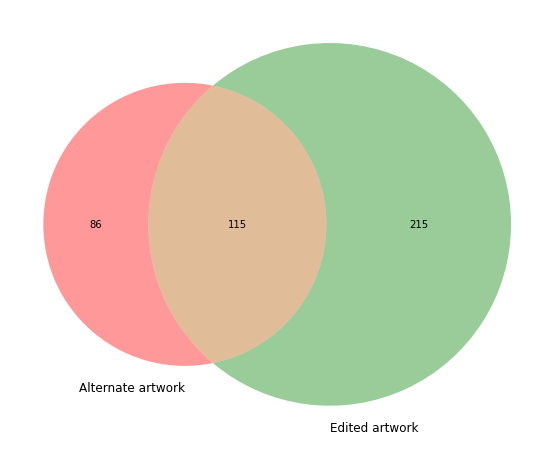

In [89]:
artwork_value_counts = formatted_full_df['Artwork'].value_counts()
plt.figure(figsize=(20,8))
venn2(subsets = (artwork_value_counts[('Alternate',)], artwork_value_counts[('Edited',)],artwork_value_counts[('Alternate','Edited')]), set_labels = ('Alternate artwork', 'Edited artwork'))
plt.show()

### By card type

In [90]:
artwork_crosstab = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Card type'])
artwork_crosstab

Card type,Monster Card,Spell Card,Trap Card
Artwork,,,
"(Alternate,)",78,3,5
"(Alternate, Edited)",78,18,19
"(Edited,)",110,62,43


### By primary type

In [91]:
artwork_crosstab_b = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Primary type'])
artwork_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster
Artwork,,,,,,,
"(Alternate,)",35,11,6,19,0,3,4
"(Alternate, Edited)",38,6,7,20,3,0,4
"(Edited,)",78,6,1,20,2,2,1


More granularity is unnecessary

## Errata

In [92]:
print('Total number of cards with name or type errata:', formatted_full_df['Errata'].count())

Total number of cards with name or type errata: 1123


In [93]:
formatted_full_df[['Name','Password','TCG status','OCG status','Errata']][formatted_full_df['Errata'].notna()]

,Name,Password,TCG status,OCG status,Errata
0,"""A"" Cell Breeding Device",34541863,Unlimited,Unlimited,"(Name,)"
9,7 Completed,86198326,Unlimited,Unlimited,"(Type,)"
10,The A. Forces,00403847,Unlimited,Unlimited,"(Type,)"
18,Abyss Playhouse - Fantastic Theater,77297908,Unlimited,Unlimited,"(Name,)"
42,Advanced Heraldry Art,61314842,Unlimited,Unlimited,"(Name,)"
...,...,...,...,...,...
11916,"Winged Dragon, Guardian of the Fortress #1",87796900,Unlimited,Unlimited,"(Name,)"
11917,"Winged Dragon, Guardian of the Fortress #2",57405307,Unlimited,Unlimited,"(Name,)"
11919,Winged Sage Falcos,87523462,Unlimited,Unlimited,"(Name,)"
11926,Wynn the Wind Charmer,37744402,Unlimited,Unlimited,"(Name,)"


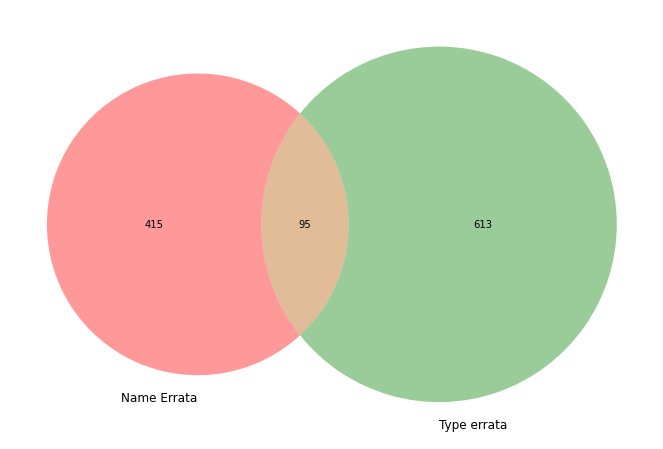

In [94]:
errata_value_counts = formatted_full_df['Errata'].value_counts()
plt.figure(figsize=(20,8))
venn2(subsets = (errata_value_counts[('Name',)], errata_value_counts[('Type',)],errata_value_counts[('Name','Type')]), set_labels = ('Name Errata', 'Type errata'))
plt.show()

### By card type

In [95]:
errata_crosstab = pd.crosstab(formatted_full_df['Errata'], formatted_full_df['Card type'])
errata_crosstab

Card type,Monster Card,Spell Card,Trap Card
Errata,,,
"(Name,)",309,56,50
"(Name, Type)",72,21,2
"(Type,)",395,209,9


### By primary type

In [96]:
errata_crosstab_b = pd.crosstab(formatted_full_df['Errata'], formatted_full_df['Primary type'])
errata_crosstab_b

Primary type,Effect Monster,Fusion Monster,Link Monster,Normal Monster,Ritual Monster,Synchro Monster,Xyz Monster
Errata,,,,,,,
"(Name,)",194,46,4,49,3,9,3
"(Name, Type)",38,10,0,17,2,5,0
"(Type,)",268,22,2,62,2,24,15


More granularity is unnecessary

### By artwork

In [97]:
errata_crosstab_c = pd.crosstab(formatted_full_df['Artwork'], formatted_full_df['Errata'])
errata_crosstab_c

Errata,"(Name,)","(Name, Type)","(Type,)"
Artwork,,,
"(Alternate,)",8,15,20
"(Alternate, Edited)",9,6,14
"(Edited,)",15,7,37


## TCG & OCG status

### TGC status

In [98]:
print('Total number of TCG status:', formatted_full_df['TCG status'].nunique())

Total number of TCG status: 7


In [99]:
formatted_full_df.groupby('TCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,OCG status,Modification date
TCG status,,,,,,,,,,,,,,,,,,,,
Forbidden,99,99,3,7,5,2,6,19,12,27,21,2,4,10,46,53,2,3,4,99
Illegal,38,0,3,3,5,0,6,14,5,11,12,2,2,2,6,7,0,1,1,38
Legal,20,0,1,0,1,0,5,11,5,6,7,0,0,0,0,13,2,1,1,20
Limited,81,81,3,7,6,3,6,15,9,20,20,3,2,2,43,40,3,3,4,81
Not yet released,8,7,1,0,3,0,4,6,8,8,6,0,0,0,6,6,0,0,1,8
Semi-Limited,9,9,3,4,2,0,3,3,1,3,3,0,0,0,8,8,1,1,3,9
Unlimited,11165,11162,3,9,7,6,7,24,14,80,75,13,6,59,340,1086,3,3,4,11040
NaN,525,426,3,9,8,2,7,23,12,54,38,6,5,9,90,118,1,1,4,519


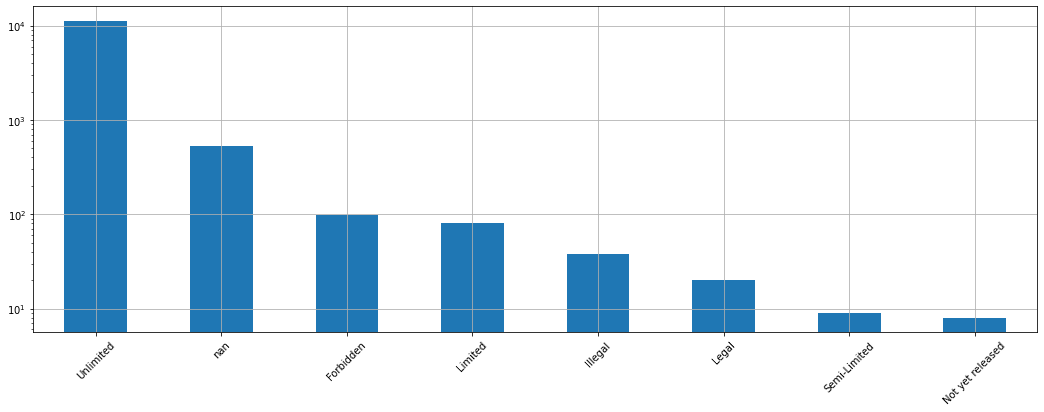

In [100]:
formatted_full_df['TCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [101]:
# Remove unlimited
tcg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Card type,,,,,,
Monster Card,64,35,20,42,8,3
Spell Card,26,2,0,34,0,5
Trap Card,9,1,0,5,0,1


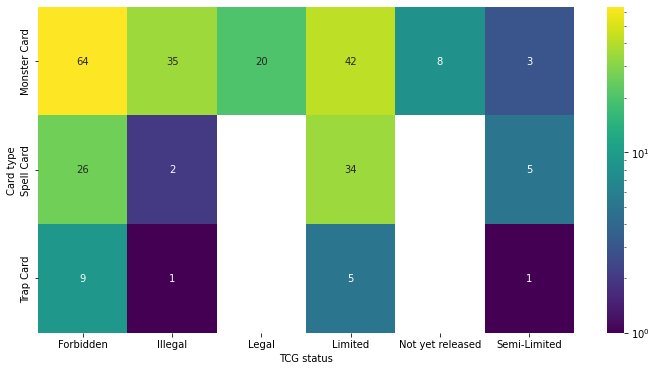

In [102]:
plt.figure(figsize = (12,6))
sns.heatmap(tcg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [103]:
# Remove unlimited
tcg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['TCG status']).drop(['Unlimited'], axis=1)
tcg_crosstab_b

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Monster type,,,,,,
Aqua,1,0,2,0,0,0
Beast,0,3,1,2,0,0
Beast-Warrior,2,3,0,2,0,0
Cyberse,2,0,0,1,0,0
Dinosaur,0,0,1,2,0,0
Divine-Beast,0,3,0,0,0,0
Dragon,10,3,1,7,3,0
Fairy,3,4,3,1,1,1
Fiend,5,2,4,3,1,0


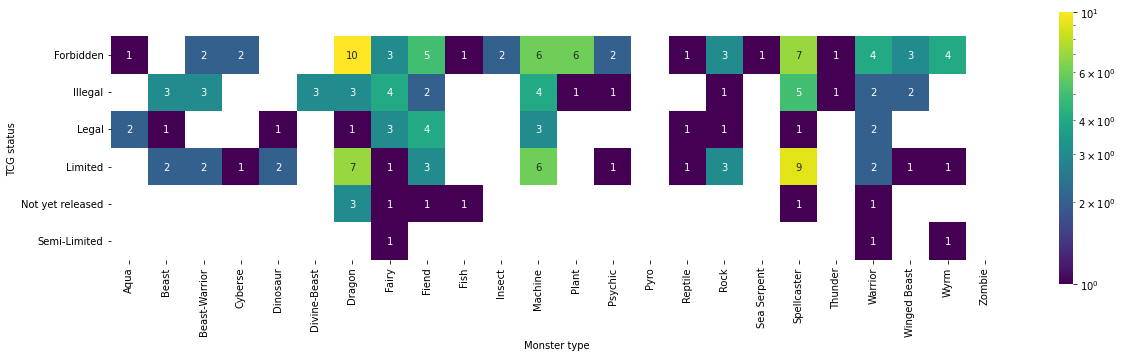

In [104]:
plt.figure(figsize = (20,5))
sns.heatmap(tcg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [105]:
# Remove unlimited
tcg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['TCG status'], margins = True)
tcg_crosstab_c

TCG status,Forbidden,Illegal,Legal,Limited,Semi-Limited,Unlimited,All
Archseries,,,,,,,
-Eyes Dragon,1,0,0,0,0,0,1
A-to-Z,0,0,0,0,0,1,1
Adventurer Token (series),0,0,0,0,0,2,2
Amazoness,0,0,0,0,0,1,1
Ancient Gear,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
Zexal,1,0,0,0,0,0,1
Zoodiac,3,0,0,1,0,0,4
roid,0,0,0,1,0,0,1


### OCG status

In [106]:
print('Total number of OCG status:', formatted_full_df['OCG status'].nunique())

Total number of OCG status: 7


In [107]:
formatted_full_df.groupby('OCG status', dropna=False).nunique()

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,DEF,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,Modification date
OCG status,,,,,,,,,,,,,,,,,,,,
Forbidden,88,88,3,6,5,4,6,19,11,28,21,3,4,7,39,43,2,3,3,88
Illegal,32,1,3,2,6,1,6,12,8,14,15,2,2,2,8,8,0,1,1,32
Legal,39,0,1,0,2,0,6,17,7,8,8,0,0,0,0,24,2,1,1,39
Limited,66,66,3,7,6,2,6,13,9,17,18,3,3,5,35,37,2,3,4,66
Not yet released,49,0,3,7,5,1,6,14,9,19,21,3,1,1,29,15,0,0,0,49
Semi-Limited,19,19,3,5,1,1,2,4,3,4,4,0,0,0,12,12,0,2,4,19
Unlimited,11585,11557,3,9,7,6,7,25,14,81,76,13,6,59,348,1113,3,3,5,11454
NaN,63,50,3,8,6,1,6,17,10,23,22,1,3,4,27,7,0,0,3,63


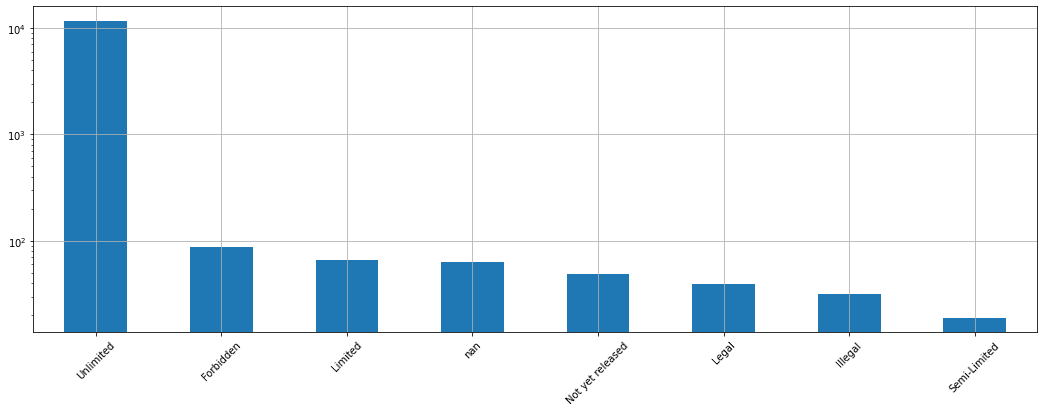

In [108]:
formatted_full_df['OCG status'].value_counts(dropna = False).plot.bar(figsize = (18,6), logy=True, grid = True, rot=45)
plt.show()

#### By card type

In [109]:
# Remove unlimited
ocg_crosstab = pd.crosstab(formatted_full_df['Card type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Card type,,,,,,
Monster Card,56,30,39,37,32,4
Spell Card,22,1,0,26,12,14
Trap Card,10,1,0,3,5,1


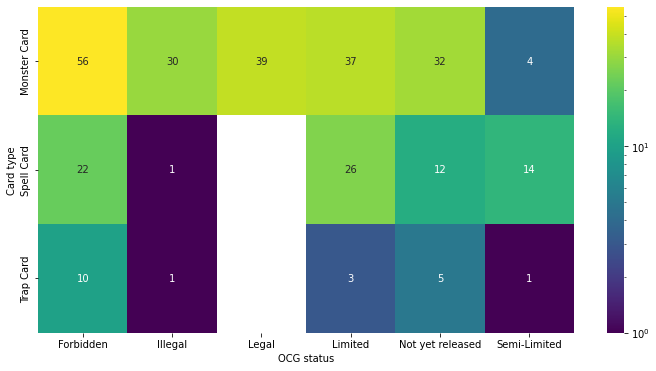

In [110]:
plt.figure(figsize = (12,6))
sns.heatmap(ocg_crosstab, annot=True, fmt="g", cmap='viridis', norm=LogNorm())
plt.show()

#### By monster type

In [111]:
# Remove unlimited
ocg_crosstab_b = pd.crosstab(formatted_full_df['Monster type'], formatted_full_df['OCG status']).drop(['Unlimited'], axis=1)
ocg_crosstab_b

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited
Monster type,,,,,,
Aqua,2,0,2,0,1,0
Beast,1,2,4,0,0,1
Beast-Warrior,3,2,0,1,1,1
Creator God,0,0,0,0,0,0
Cyberse,2,0,2,1,0,0
Dinosaur,0,0,1,1,1,0
Divine-Beast,0,3,0,0,0,0
Dragon,10,3,1,4,7,0
Fairy,2,3,4,1,2,0


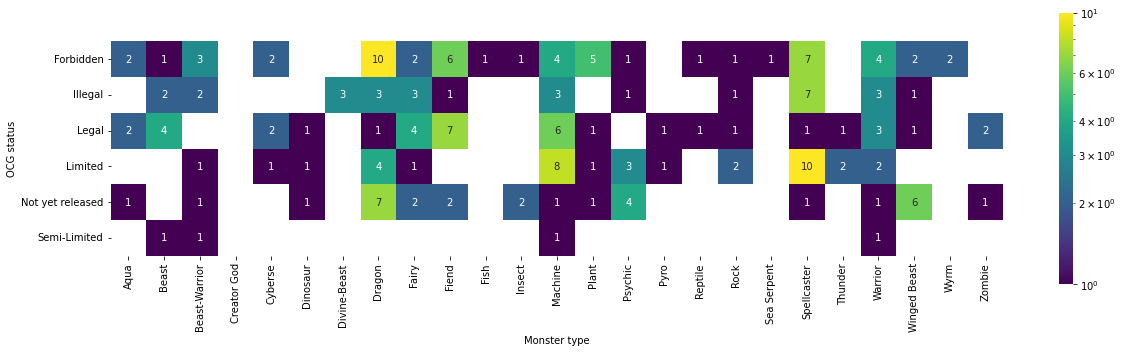

In [112]:
plt.figure(figsize = (20,5))
sns.heatmap(ocg_crosstab_b.T, annot=True, fmt="g", cmap='viridis', square = True, norm=LogNorm())
plt.show()

#### By archseries

In [113]:
# Remove unlimited
ocg_crosstab_c = pd.crosstab(exploded_archseries['Archseries'].where(exploded_archseries['OCG status']!='Unlimited'), exploded_archseries['OCG status'], margins = True)
ocg_crosstab_c

OCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited,All
Archseries,,,,,,,
-Eyes Dragon,1,0,0,0,0,0,1
A-to-Z,0,0,0,1,0,0,1
Adventurer Token (series),0,0,0,2,0,0,2
Amazoness,1,0,0,0,0,0,1
Ancient Gear,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
Zombie counterpart,0,0,1,0,0,0,1
Zoodiac,2,0,0,2,0,0,4
roid,0,0,0,1,0,0,1


### TCG vs. OCG status

In [114]:
cg_crosstab = pd.crosstab(formatted_full_df['OCG status'],formatted_full_df['TCG status'], dropna=False, margins = False)
cg_crosstab

TCG status,Forbidden,Illegal,Legal,Limited,Not yet released,Semi-Limited,Unlimited
OCG status,,,,,,,
Forbidden,71,0,0,6,0,0,11
Illegal,0,26,0,0,0,0,0
Legal,0,0,20,0,0,0,0
Limited,8,0,0,33,0,3,22
Semi-Limited,1,0,0,5,0,3,10
Unlimited,19,0,0,37,7,3,11074


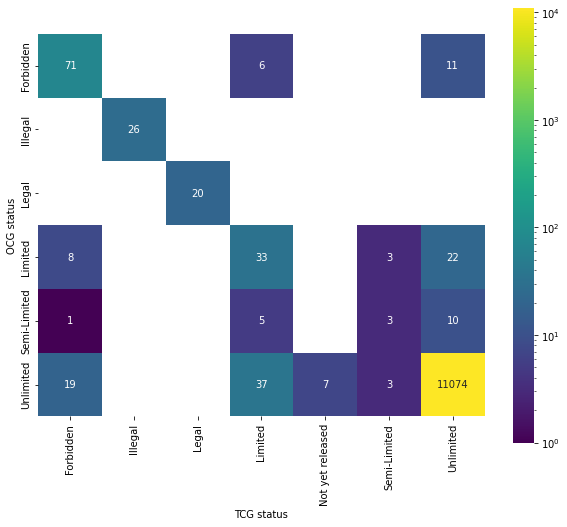

In [115]:
plt.figure(figsize = (10,8))
sns.heatmap(cg_crosstab, annot=True, fmt="g", cmap='viridis', square=True, norm=LogNorm())
plt.show()

# HTML export

In [120]:
! jupyter nbconvert Cards.ipynb --to=HTML --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook Cards.ipynb to HTML
[NbConvertApp] Writing 2750692 bytes to Cards.html


# Searches

In [117]:
formatted_full_df.loc[formatted_full_df['OCG status'] == 'Not yet released'].loc[formatted_full_df['TCG status'] == 'Not yet released']

,Name,Password,Card type,Property,Primary type,Secondary type,Attribute,Monster type,Level/Rank,ATK,...,Pendulum Scale,Link,Link Arrows,Effect type,Archseries,Artwork,Errata,TCG status,OCG status,Modification date


# Git push

In [22]:
! git add .

In [38]:
! git commit -m {"Update-" + pd.Timestamp.now().strftime("%d%m%Y")}

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Cards.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [24]:
! git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.20 KiB | 1.20 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/guigoruiz1/yugiquery.git
   5ce02b3..a3e835f  main -> main
